# Vision Transformer for VALDO Dataset

This version is based on: https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

## Imports

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import nibabel as nib
import numpy as np
import pandas as pd
import math
import cv2

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from transformers import ViTForMaskedImageModeling, ViTFeatureExtractor

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging

# Set the logging level for nibabel.global to WARNING to suppress INFO messages
logging.getLogger('nibabel.global').setLevel(logging.WARNING)

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some labels exceed the number of classes. Clamping labels.")


In [3]:
class VALDODataset(Dataset):
    def __init__(self, cases, masks, transform):
        self.cases = cases
        self.masks = masks
        self.transform = transform
        self.cmb_counts = self.count_cmb_per_image(self.masks)

        assert len(self.cases) == len(self.masks), 'Cases and masks must have the same length'
    
    def __len__(self):
        return len(self.cases)
    
    def __getitem__(self, idx):
        try:
            case = self.cases[idx]
            mask = self.masks[idx]

            slices = []
            masks = []

        
            s, m = self.transform(mri_image_path=case, segmentation_mask_path=mask)
            if s is None or m is None:
                raise ValueError(f"Transform returned None for {case} and {mask}")
            
            
            slices.append(s)
            masks.append(m)
            
            # print(f'Loaded image {case} and mask {mask}')
            return slices, masks, case, self.cmb_counts[idx]

        except Exception as e:
            print(f'Error loading image: {e}')
            return None, None, None, None
    
    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([(x-(w/2.5)), (y-(h/2.5)), ((w+x) + (w/3)), ((h+y) + (h/3))])
            # boxes.append([x, y, x +     w, y + h])
        return boxes

    def count_cmb_per_image(self, segmented_images):
        cmb_counts = []
        for img_path in segmented_images:
            img = nib.load(img_path)
            data = img.get_fdata()
            slice_cmb_counts = [self.extract_bounding_boxes(
                (data[:, :, i] > 0).astype(np.uint8)) for i in range(data.shape[2])]
            total_cmb_count = sum(len(contours)
                                  for contours in slice_cmb_counts)
            cmb_counts.append(total_cmb_count)
        return cmb_counts


## Transform

In [4]:
# logging.getLogger('nibabel').setLevel(logging.WARNING)
# def load_nifti(file_path):
#     try:
#         nifti = nib.load(file_path)
#         data = nifti.get_fdata()
#         # print(f"Loaded NIfTI data shape: {data.shape}")
#         return data
#     except Exception as e:
#         print(f"Error loading NIfTI file {file_path}: {e}")
#         return None

# class NiftiToTensorTransform:
#     def __init__(self, target_shape=(256, 256), in_channels=1):
#         self.target_shape = target_shape
#         self.in_channels = in_channels
#         self.transform = A.Compose([
#             A.Resize(height=target_shape[0], width=target_shape[1], p=1.0, always_apply=True),
#             ToTensorV2()
#         ], is_check_shapes=False)  # Disable shape checking if you are sure about your data consistency

#     def convert_to_binary_mask(self, segmentation_mask):
#         binary_mask = (segmentation_mask > 0).astype(np.uint8)
#         return binary_mask

#     def __call__(self, mri_image_path, segmentation_mask_path):
#         try:
#             # Load the images
#             mri_image = load_nifti(mri_image_path)
#             segmentation_mask = load_nifti(segmentation_mask_path)
#             dim_img = nib.load(mri_image_path).header['dim'][0]
#             seg_img = nib.load(segmentation_mask_path).header['dim'][0]

#             if mri_image is None or segmentation_mask is None:
#                 raise ValueError("Failed to load NIfTI files or data is None.")

#             # Convert multi-label mask to binary mask
#             # binary_mask = self.convert_to_binary_mask(segmentation_mask)

#             if mri_image.shape[0] != dim_img:
#                 # If the number of channels is not equal to dim, adjust it
#                 mri_image = np.repeat(mri_image, dim_img, axis=0)
            
#             if segmentation_mask.shape[0] != seg_img:
#                 # If the number of channels is not equal to dim, adjust it
#                 mri_image = np.repeat(mri_image, dim_img, axis=0)
#             # Apply transformations to the entire volume
#             augmented = self.transform(image=mri_image, mask=segmentation_mask)
#             image = augmented['image']
#             mask = augmented['mask']

#             # # Ensure the number of channels matches the expected input channels
#             # if image.shape[0] != self.in_channels:
#             #     raise ValueError(f"Expected {self.in_channels} input channels, but got {image.shape[0]} channels. Channels should be {self.in_channels}. MRI Image is {mri_image.shape}")

            
#             # Debugging prints
#             # print(f"Image shape after transform: {image.shape}")
#             # print(f"Mask shape after transform: {mask.shape}")
#             # print(f"Unique values in the transformed mask: {torch.unique(mask)}")

#             return image, mask
#         except Exception as e:
#             print(f"Error in __call__ with {mri_image_path} and {segmentation_mask_path}: {e}")
#             return None, None


In [5]:
logging.getLogger('nibabel').setLevel(logging.WARNING)

def load_nifti(file_path):
    try:
        nifti = nib.load(file_path)
        data = nifti.get_fdata()
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

class NiftiToTensorTransform:
    def __init__(self, target_shape=(256, 256), in_channels=1):
        self.target_shape = target_shape
        self.in_channels = in_channels
        self.transform = A.Compose([
            A.Resize(height=target_shape[0], width=target_shape[1], p=1.0, always_apply=True),
            ToTensorV2(p=1.0)
        ], is_check_shapes=False)  # Disable shape checking if you are sure about your data consistency

    def convert_to_binary_mask(self, segmentation_mask):
        binary_mask = (segmentation_mask > 0).astype(np.uint8)
        return binary_mask

    def __call__(self, mri_image_path, segmentation_mask_path):
        try:
            mri_image = load_nifti(mri_image_path)
            segmentation_mask = load_nifti(segmentation_mask_path)

            if mri_image is None or segmentation_mask is None:
                raise ValueError("Failed to load NIfTI files or data is None.")

            segmentation_mask = self.convert_to_binary_mask(segmentation_mask)
            
            # Apply transformations to each slice separately
            image_slices = []
            mask_slices = []
            for i in range(mri_image.shape[2]):
                augmented = self.transform(image=mri_image[:, :, i], mask=segmentation_mask[:, :, i])
                image_slices.append(augmented['image'].unsqueeze(0))  # Add channel dimension
                mask_slices.append(augmented['mask'].unsqueeze(0))    # Add channel dimension
                # image_slices.append(augmented['image'])
                # mask_slices.append(augmented['mask'])
            # Stack slices and add batch dimension
            # image = torch.stack(image_slices).unsqueeze(0)  # Shape: [1, slices, 256, 256]
            # mask = torch.stack(mask_slices).unsqueeze(0)    # Shape: [1, slices, 256, 256]
            image = torch.stack(image_slices)  # Shape: [slices, 1, 256, 256]
            mask = torch.stack(mask_slices)    # Shape: [slices, 1, 256, 256]
            # Ensure the final shape is [1, 1, 256, 256]
            print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
            if image.shape[1] != 1 or mask.shape[1] != 1:
        
                raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")
            

            return image, mask
        except Exception as e:
            print(f"Error in __call__ with {mri_image_path} and {segmentation_mask_path}: {e}")
            print("Traceback", traceback.format_exc())
            return None, None

In [6]:
transform = NiftiToTensorTransform()

## Load the data

### Dataloader

In [7]:
testing_label_relative = '../VALDO_Dataset/Task2'
current_directory = os.getcwd()

two_directories_up = os.path.abspath(os.path.join(current_directory, "../"))

# Combine the current directory with the relative path
testing_label_absolute = os.path.join(
    two_directories_up, testing_label_relative)

folders = [item for item in os.listdir(testing_label_absolute) if os.path.isdir(
    os.path.join(testing_label_absolute, item))]

cases = {"cohort1": [], "cohort2": [], "cohort3": []}
# Print the list of folders
for folder in folders:
    if "sub-1" in folder:
        cases["cohort1"].append(folder)
    elif "sub-2" in folder:
        cases["cohort2"].append(folder)
    else:
        cases["cohort3"].append(folder)

In [8]:
cohort1_labels = []
cohort1_ids = []
for case in cases["cohort1"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort1_labels.append(label)
    cohort1_ids.append(id)
# print("Label:", cohort1_labels, cohort1_labels.__len__())
# print("Ids:", cohort1_ids, cohort1_ids.__len__())

cohort2_labels = []
cohort2_ids = []
for case in cases["cohort2"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort2_labels.append(label)
    cohort2_ids.append(id)
# print("Label:", cohort2_labels, cohort2_labels.__len__())
# print("Ids:", cohort2_ids, cohort2_ids.__len__())

cohort3_labels = []
cohort3_ids = []
for case in cases["cohort3"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort3_labels.append(label)
    cohort3_ids.append(id)
# print("Label:", cohort3_labels, cohort3_labels.__len__())
# print("Ids:", cohort3_ids, cohort3_ids.__len__())

all_labels = cohort1_labels + cohort2_labels + cohort3_labels
all_ids = cohort1_ids + cohort2_ids + cohort3_ids

# print(all_labels[0])
# print(all_ids[0])

In [9]:
print("Length of cohort1: ", len(cases["cohort1"])) 

Length of cohort1:  11


# Global Variables

In [10]:
d_model = 3
n_classes = 2
img_size = (256,256)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 1
epochs = 5
alpha = 0.004

### Collate 

In [11]:
def collate_fn(batch):
    slices = []
    targets = []
    img_paths = []
    cmb_counts = []

    for item in batch:
        if item is not None:  # Skip None items
            item_slices, item_targets, item_img_path, item_cmb_counts = item
            slices.extend(item_slices)
            targets.extend(item_targets)
            img_paths.append(item_img_path)
            cmb_counts.append(item_cmb_counts)

    if slices:
        cases = torch.stack(slices, dim=0)
        masks = torch.stack(targets, dim=0)
        return cases, masks, img_paths, cmb_counts
    else:
        return None, None, [], []

In [12]:
# dataset = VALDODataset(
#     cases=all_ids, masks=all_labels, transform=transform)

dataset = VALDODataset(
    cases=cohort1_ids, masks=cohort1_labels, transform=transform)

In [13]:
print(type(dataset))
print(len(dataset))

<class '__main__.VALDODataset'>
11


In [14]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

# df_dataset

In [15]:
train_df, val_df = train_test_split(
    df_dataset, test_size=0.2, stratify=df_dataset['Has CMB'], random_state=42)

In [16]:
print(val_df)

                                           MRI Scans  \
8  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
9  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
6  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   

                                     Segmented Masks  CMB Count  Has CMB  
8  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....          0        0  
9  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....        100        1  
6  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....          2        1  


In [17]:
train_dataset = VALDODataset(train_df['MRI Scans'].tolist(
), train_df['Segmented Masks'].tolist(), transform=transform)
val_dataset = VALDODataset(val_df['MRI Scans'].tolist(
), val_df['Segmented Masks'].tolist(), transform=transform)

In [18]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_fn)

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
<class 'list'>
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Image shape:  torch.Size([35, 1, 1, 256, 256])
Annotations shape:  torch.Size([35, 1, 256, 256])
35
Input shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Number of slices:  35


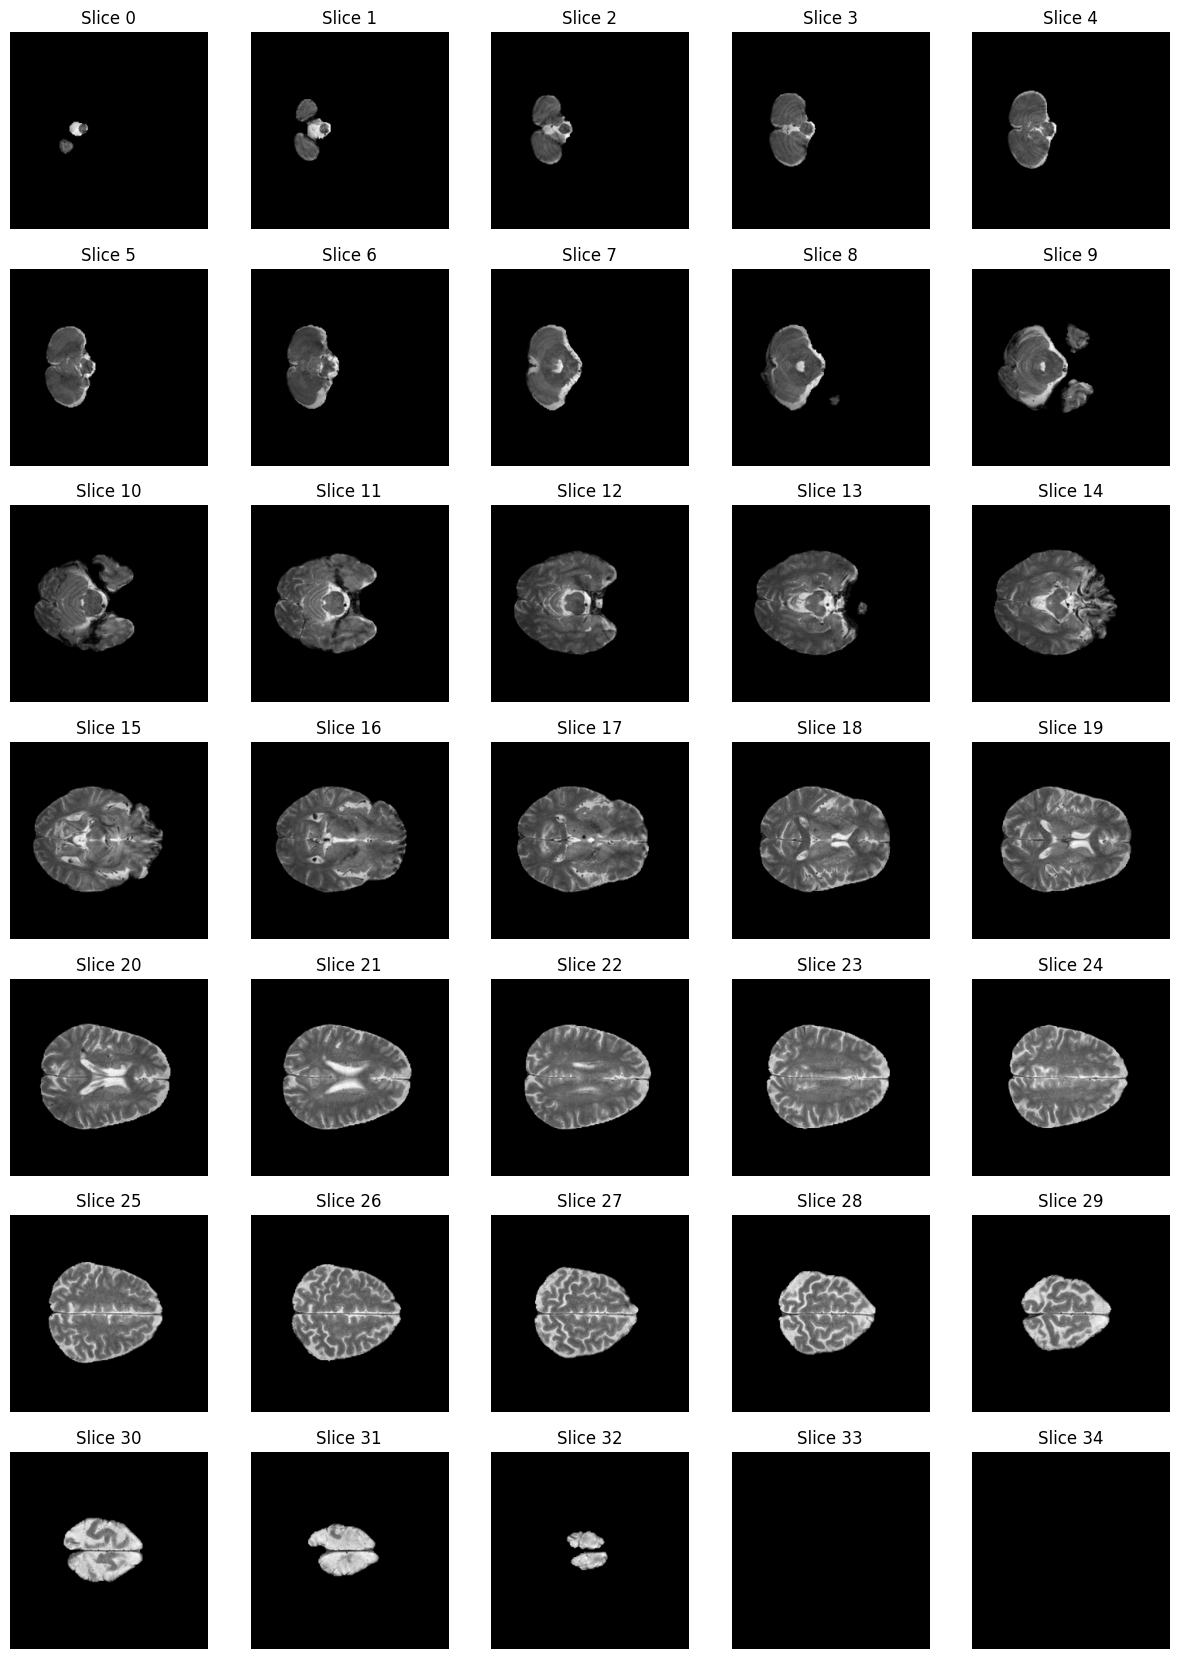

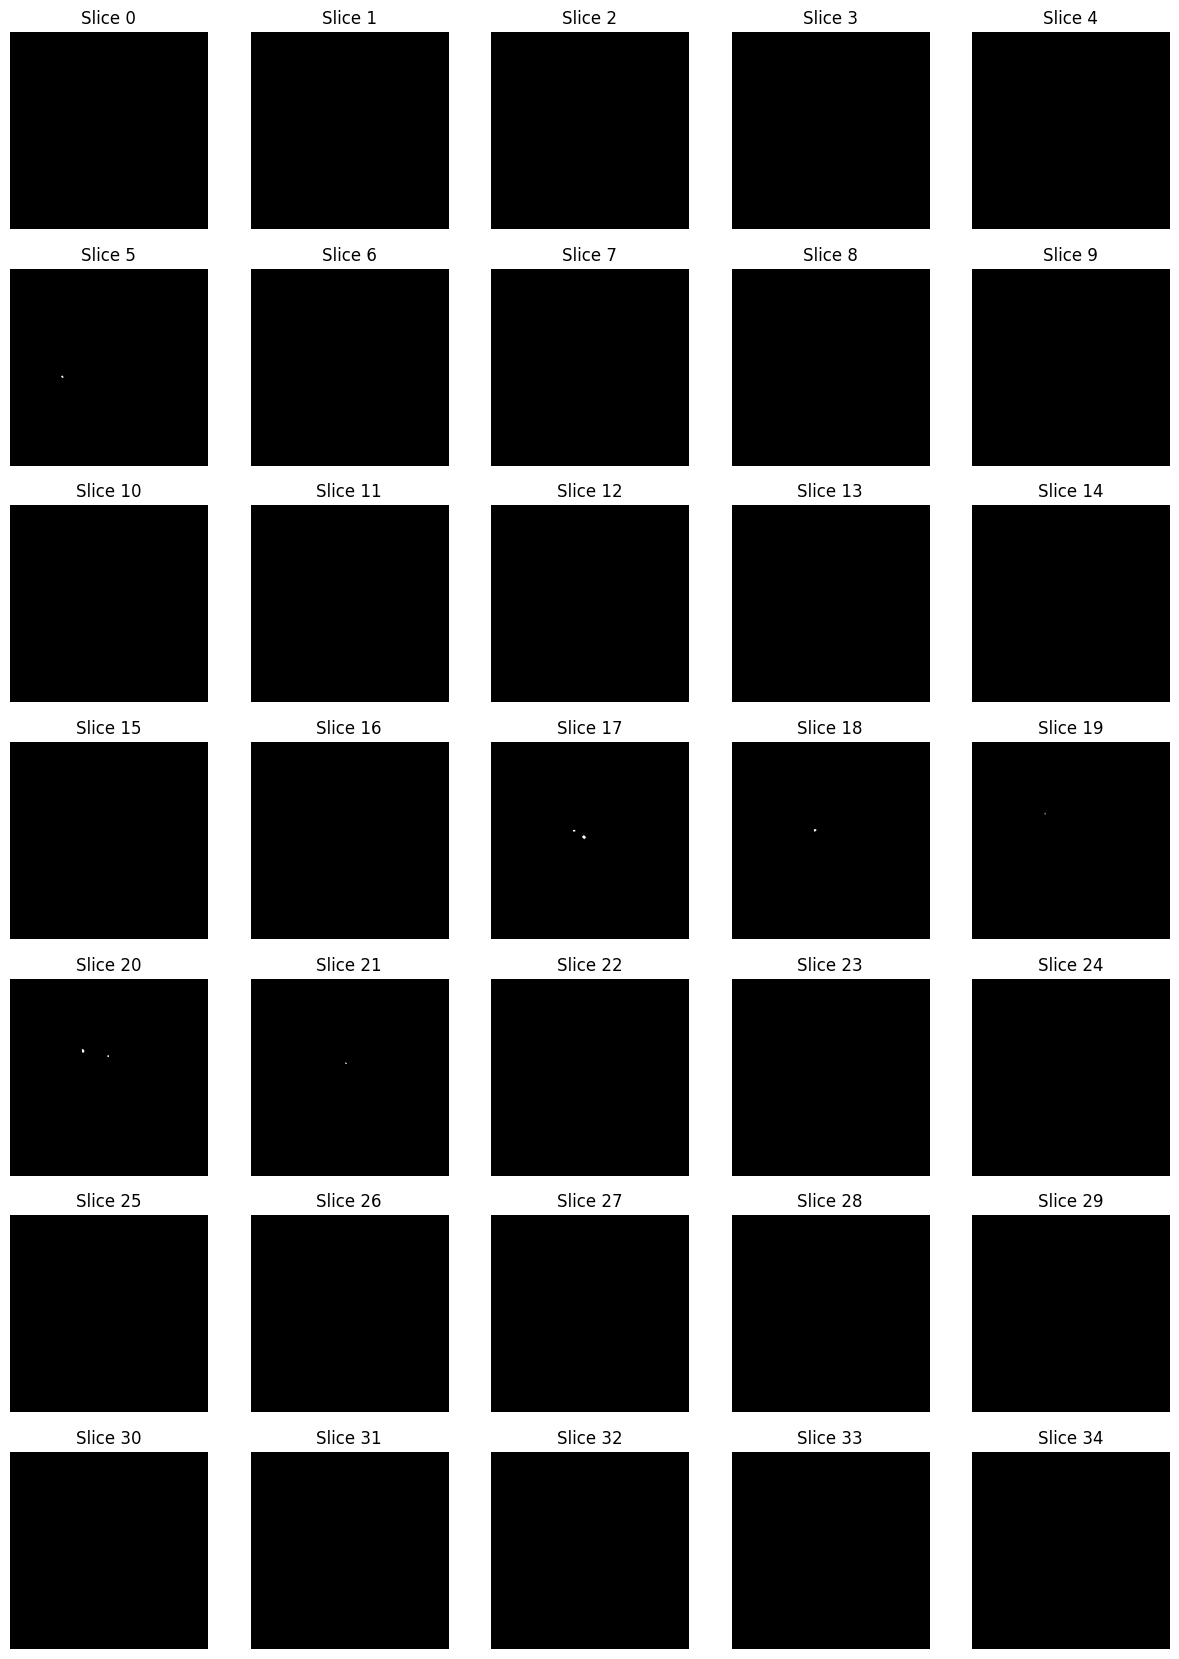

In [19]:
# Plot multiple slices
slice = 25
data = train_loader.__getattribute__('dataset')[5]

# Print information about data
print(type(data[0]))
print(type(data[1]))
print(type(data[0][0]))
print(type(data[1][0]))
print("Image shape: ", data[0][0].shape)
print("Annotations shape: ", data[1][0].shape)
print(len(data[0][0]))

# Select input and mask for the specified slice
inpt = data[0][0][slice].squeeze(0).squeeze(0)  # Remove the extra dimensions
mask = data[1][0][slice].squeeze(0).squeeze(0)  # Remove the extra dimensions

print("Input shape:", inpt.shape)
print("Mask shape:", mask.shape)

# Number of slices
num_slices = len(data[0][0])
print("Number of slices: ", num_slices)

# Set the number of columns for subplots
num_columns = 5  # Adjust as needed

# Calculate the number of rows required to display all slices
num_rows = (num_slices - 1) // num_columns + 1

# Plot input slices
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i < num_slices:
        s = data[0][0][i].squeeze(0).squeeze(0)  # Remove the extra dimensions
        ax.imshow(s.cpu(), cmap='gray')
        ax.set_title(f'Slice {i}')
    ax.axis('off')

plt.show()

# Plot mask slices
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i < num_slices:
        ax.imshow(data[1][0][i].squeeze(0).squeeze(0).cpu(), cmap='gray')  # Remove the extra dimensions
        ax.set_title(f'Slice {i}')
    ax.axis('off')

plt.show()


In [20]:
# for i, data in enumerate(train_loader, 0): 
#     print(i)
#     inpt = data[0][0]
#     mask = data[1][0][0][4]
#     print("Input", len(inpt))
#     print("Mask", len(mask))
#     print("Input", inpt.shape)
#     print("Mask", mask.shape)
#     break

## CUDA

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Patch Embeddings

**B**: Batch Size <br>
**C** : Image channels  <br>
**H**: Image Height <br>
**W**: Image Width  <br>
**P_col**: Patch Columns  <br>
**P_row**: Patch Rows  <br>

In [22]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)
  def forward(self, x):
    # print("inpt is ", x.shape)
    x = x.unsqueeze(0)
    # print(x.shape)
    # Average across the 35-dimension
    x = torch.mean(x, dim=2)
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)

    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)

    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)
    
    return x

In [23]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()

    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, d_model)

    for pos in range(max_seq_length):
      for i in range(d_model):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Expand to have class token for every image in batch
    tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

    # Adding class tokens to the beginning of each embedding
    x = torch.cat((tokens_batch,x), dim=1)

    # Add positional encoding to embeddings
    x = x + self.pe

    return x

In [24]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

In [25]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    # Combine attention heads
    out = torch.cat([head(x) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

In [26]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [27]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [28]:
class SegmentationHead(nn.Module):
    def __init__(self, n_channels, num_classes, image_size, patch_size, d_model):
        super(SegmentationHead, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.d_model = d_model
        # Adjusted convolutional layer with embed_dim as input channels and num_classes output channels
        self.conv = nn.Conv2d(self.n_channels, self.d_model, kernel_size=1, stride=self.patch_size)

    def forward(self, x, masks=None):
        batch_size, embed_dim, side_length = x.shape  # Assuming x has shape [batch_size, embed_dim, side_length]

        # Reshape x if necessary to match the input channels expected by self.conv
        # print("Before squeeze:", x.shape)
        x = x.unsqueeze(1)  # Add a channel dimension if it's missing
        
        # Apply convolution to get segmentation logits
        # print(x.shape)
        x = self.conv(x)

        # If masks are provided, compute the loss
        if masks is not None:
            x = x.to(device)
            masks = masks.to(device)
            # print("Inputs shape: ", x.shape)
            # print("Masks shape: ", masks.shape)
            x = nn.functional.interpolate(x, size=(masks.shape[1], masks.shape[2]), mode='bilinear')
            masks = masks.long()  # Convert masks to long tensor if necessary

            # Reshape masks if necessary
            # if masks.dim() == 3:
            masks = masks.squeeze(1)
            loss_fn = nn.CrossEntropyLoss()

            loss = loss_fn(x, masks)
            print("Loss: ", loss)
            return x, loss
        else:
            return x


In [29]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])
    self.segmentation_head = SegmentationHead(self.n_channels, self.n_classes, self.img_size, self.patch_size, self.d_model)


  def forward(self, images, mask=None):
    x = self.patch_embedding(images)
    # print("After patch embedding:", x.shape)
    x = self.positional_encoding(x)
    # print("After positional encoding:", x.shape)
    x = self.transformer_encoder(x)
    # print("After transformer encoder:", x.shape)
    x = self.segmentation_head(x, mask)

    return x

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [31]:
torch.backends.cudnn.benchmark = False


In [32]:
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)


In [33]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()


In [35]:
for epoch in range(epochs):
  training_loss = 0.0
  for i, data in tqdm(enumerate(train_loader, 0), desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}'):
    print("Leraning case: ", i)
    num_slices = len(data[0][0])
    for j in range(num_slices):
        inputs = data[0][0][i].float()
        mask = data[1][0][i].float()
        inputs, labels = inputs.to(device), mask.to(device)
        print(f'Learning case {i} slice {j}')
        # labels = labels.squeeze(-1)
        # labels = torch.argmax(labels, dim=-1)
        optimizer.zero_grad()
        outputs = transformer(inputs, mask)
        outputs, loss = outputs
        # print("Outputs: ", type(outputs))
        outputs = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
        # print("Outputs: ", outputs)
        # print("Labels: ", labels)
        if labels.max() >= n_classes:
        # print("Warning: Some labels exceed the number of classes. Clamping labels.")
            labels = torch.clamp(labels, 0, n_classes - 1)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

  print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')

Epoch 1/5 loss: 0.000: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
Leraning case:  0
Learning case 0 slice 0
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(0.9179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 1
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(0.8959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 2
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256,

Epoch 2/5 loss: 0.000: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
Leraning case:  0
Learning case 0 slice 0
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(0.0002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 1
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(0.0002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 2
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256,

Epoch 3/5 loss: 0.000: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
Leraning case:  0
Learning case 0 slice 0
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(4.9815e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 1
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(4.9611e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 2
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size(

Epoch 4/5 loss: 0.000: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
Leraning case:  0
Learning case 0 slice 0
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(2.0272e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 1
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(2.0224e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 2
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size(

Epoch 5/5 loss: 0.000: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
Leraning case:  0
Learning case 0 slice 0
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(1.0779e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 1
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size([1, 256, 256])
Loss:  tensor(1.0759e-05, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Learning case 0 slice 2
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
Inputs shape:  torch.Size([1, 3, 17, 1])
Masks shape:  torch.Size(

In [36]:
import os

dir_path = 'experiments'
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model weights
model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers)
model.to(device)
model.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
model.eval()

def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
    return prediction.cpu().numpy()

# Make a prediction
val_loss = 0.0
predicted = []

length = len(test_loader)
case = 0 
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(train_loader, 0), desc=f'Case {case + 1}/{0}'):
        num_slices = len(val_batch[0][0])
        for j in range(num_slices):
            val_images = val_batch[0][0][j].float().to(device)
            val_masks = val_batch[1][0][j].float().to(device)  # Convert ground truth to long
            predicted_mask = predict(model, val_images)

            # Resize predicted_mask to match val_masks size
            predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()  # Convert to float for loss calculation
            predicted_mask = F.interpolate(predicted_mask, size=img_size, mode='nearest').squeeze(1)

            val_loss += criterion(predicted_mask, val_masks).item()  # Ensure val_masks is long
            predicted.append(predicted_mask)
            print("predicted_mask", predicted_mask)
            print("val_masks", val_masks)

print(f'Validation Loss: {val_loss}')

Case 1/0: 0it [00:00, ?it/s]

Image shape: torch.Size([35, 1, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
predicted_mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
val_masks tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
After patch embedding: torch.Size([1, 256, 3])
After positional encoding: torch.Size([1, 257, 3])
After transformer encoder: torch.Size([1, 257, 3])
predicted_mask tensor([[[0., 0

In [59]:
print(len(predicted))
print(len(test_loader))

280
3


In [76]:
for prediction in predicted:
    print("Prediction shape: ", prediction.shape)
    print(prediction[0][0].shape)
    print("Unique values in prediction: ", torch.unique(prediction))

Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape:  torch.Size([1, 256, 256])
torch.Size([256])
Unique values in prediction:  tensor([0.], device='cuda:0')
Prediction shape

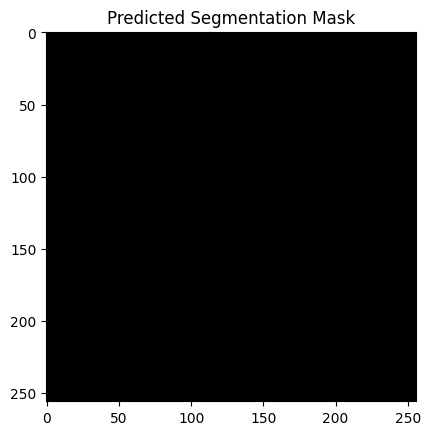

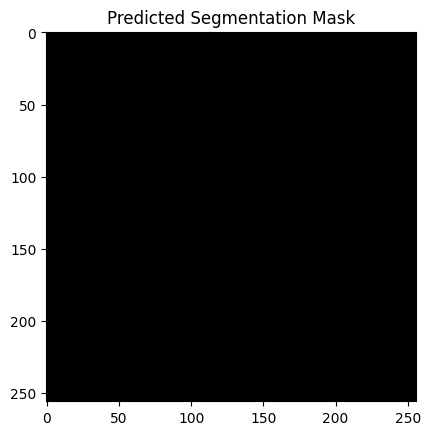

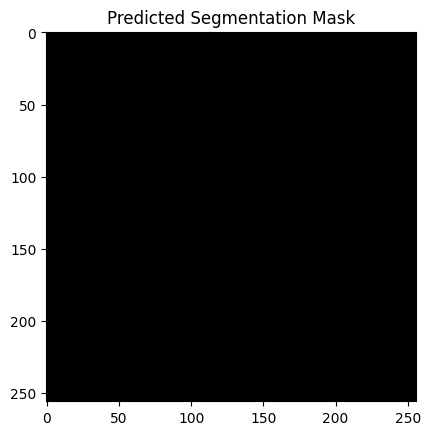

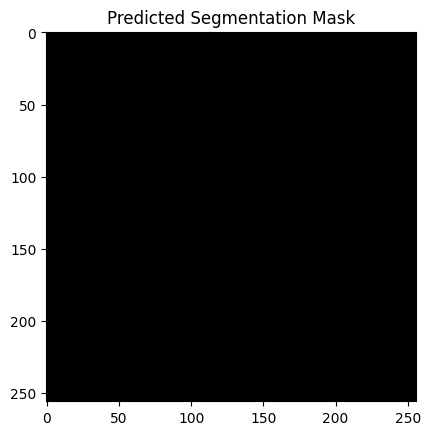

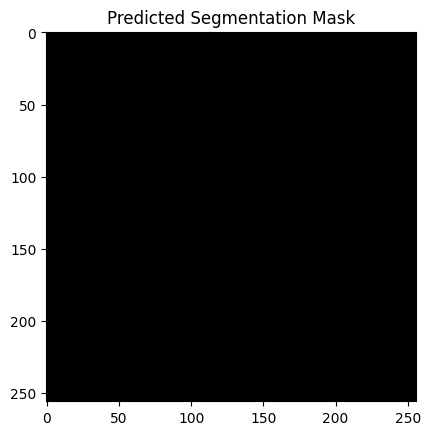

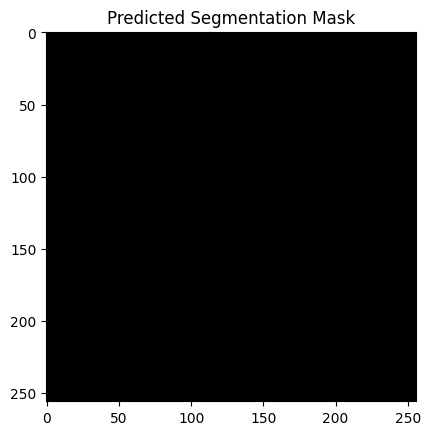

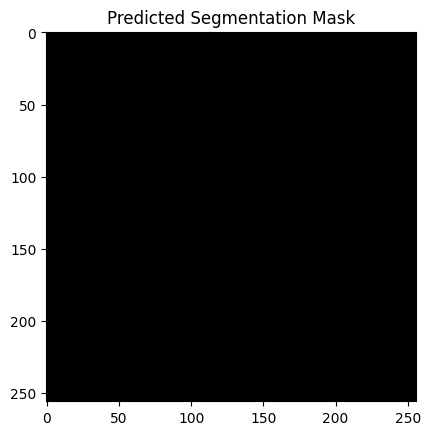

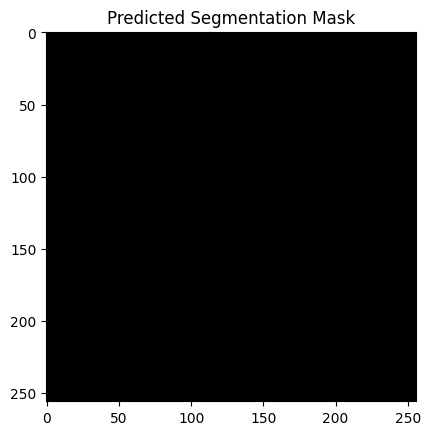

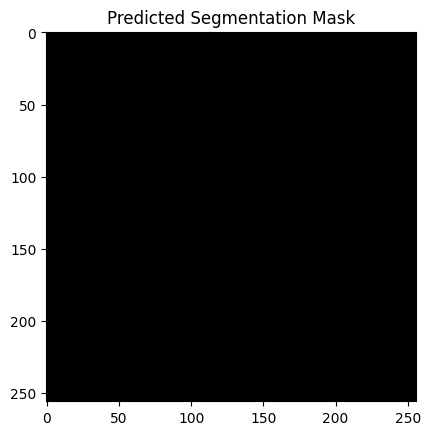

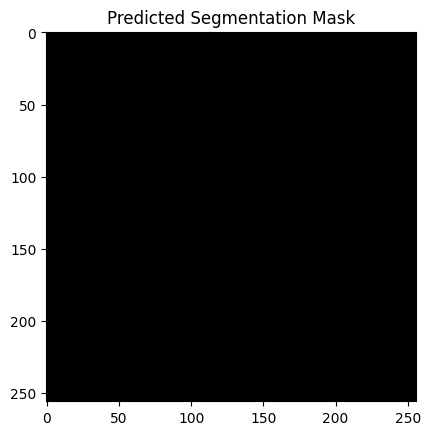

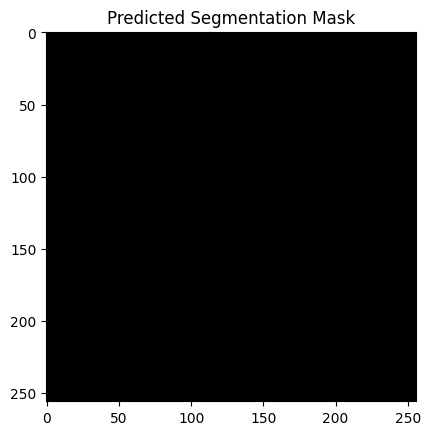

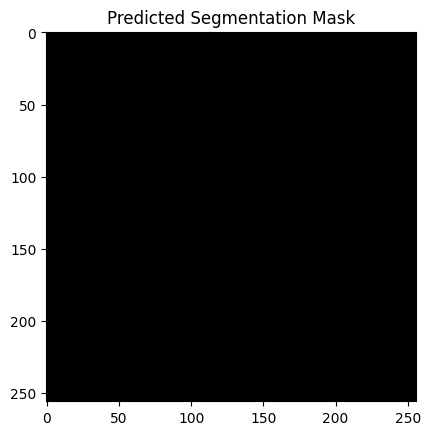

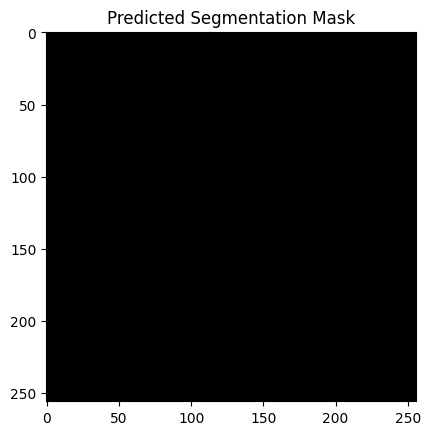

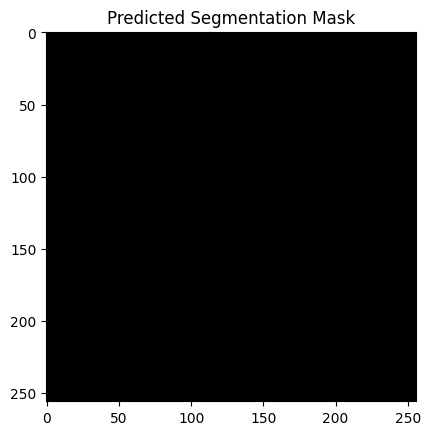

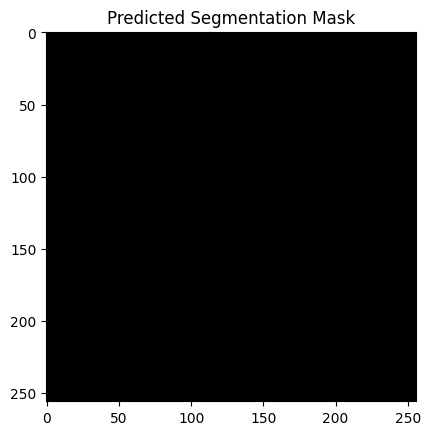

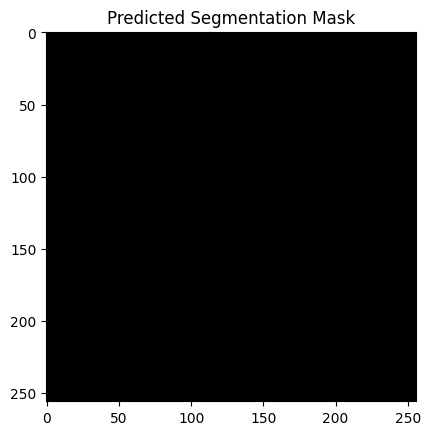

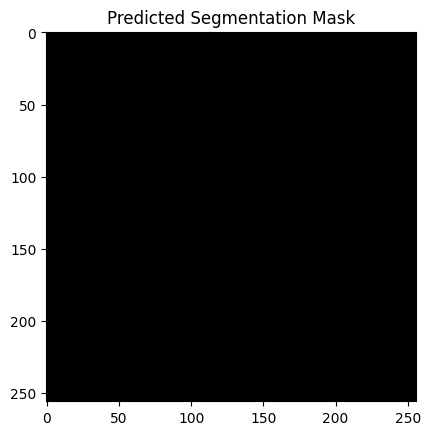

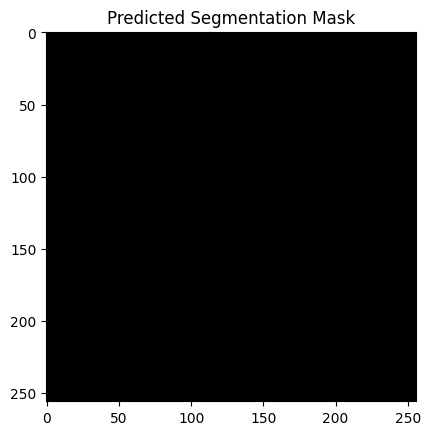

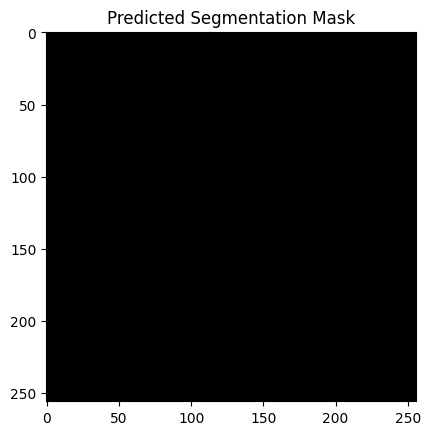

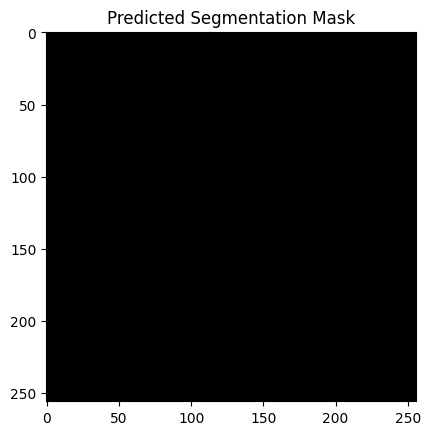

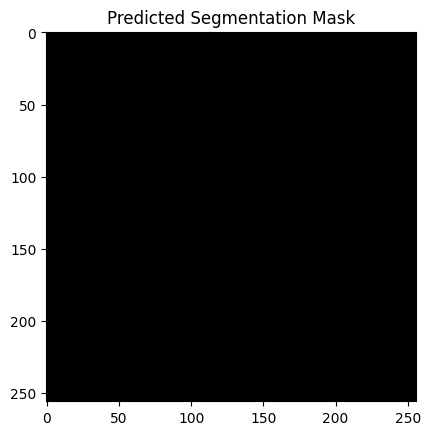

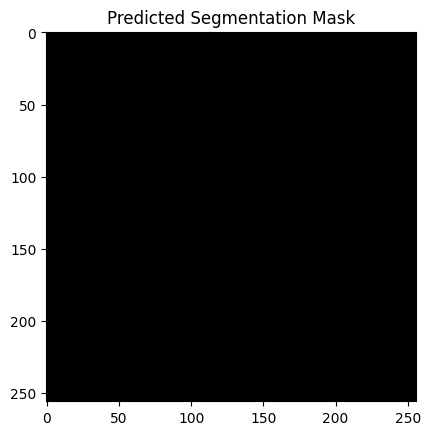

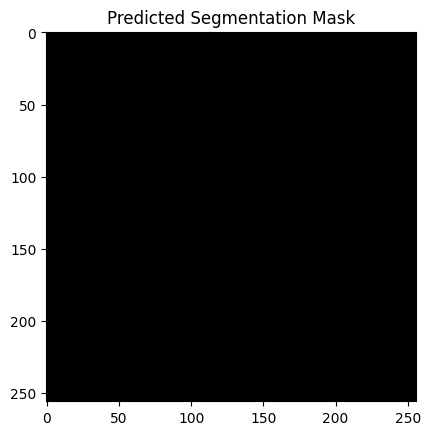

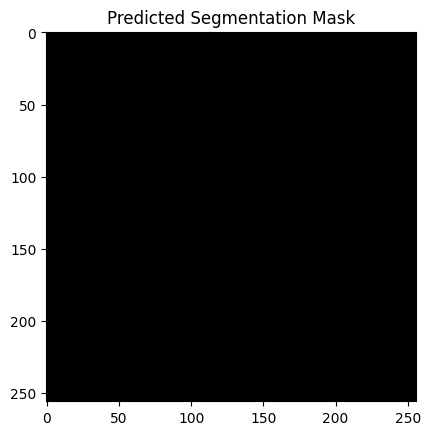

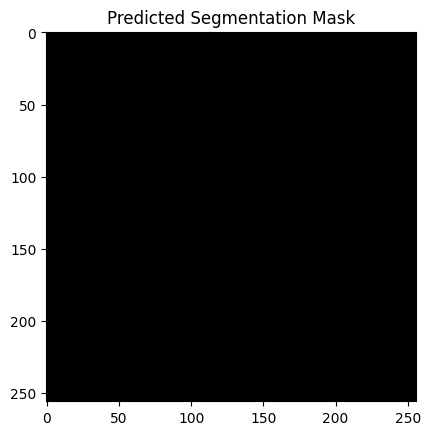

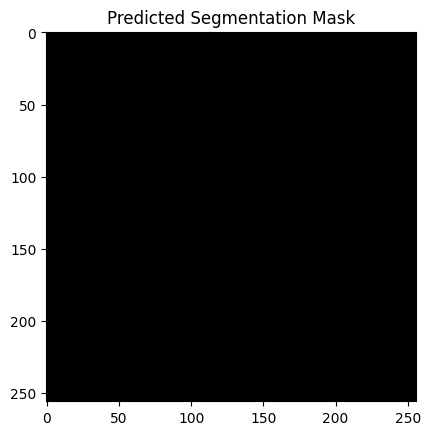

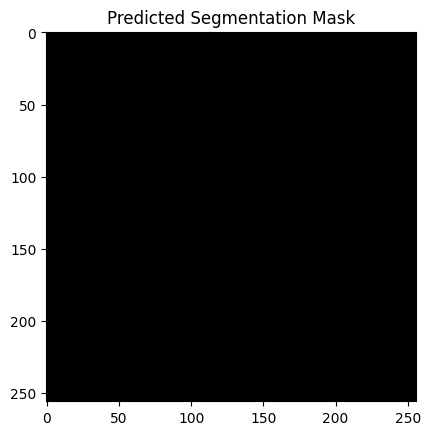

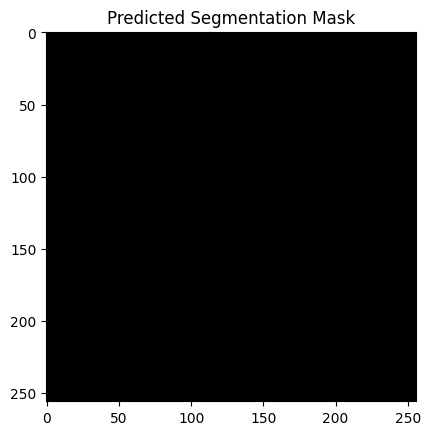

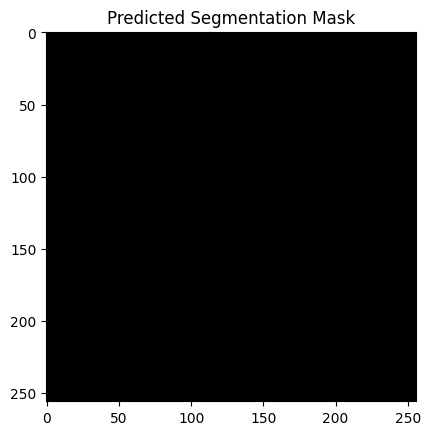

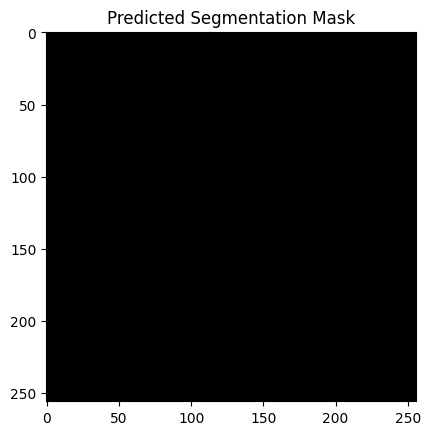

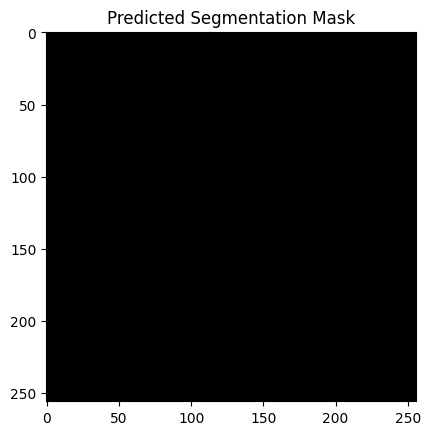

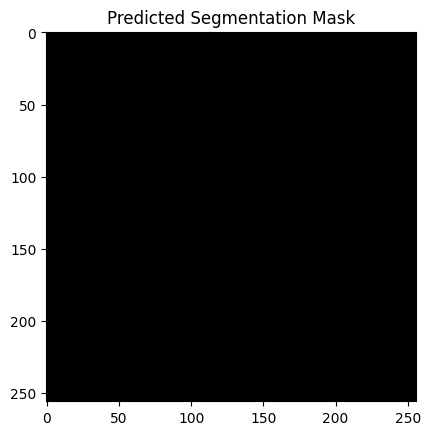

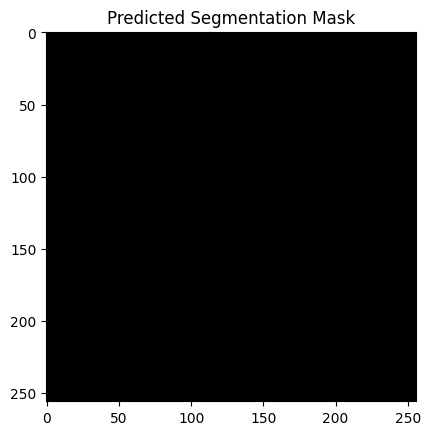

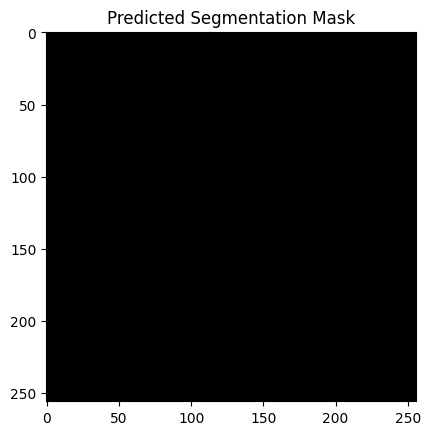

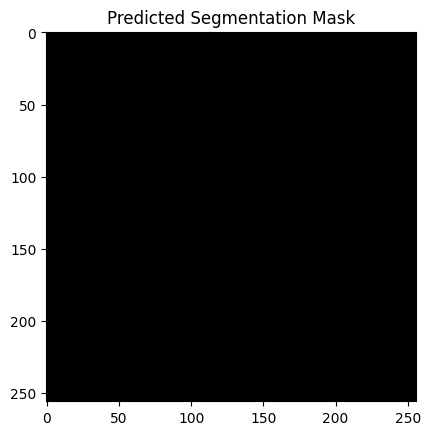

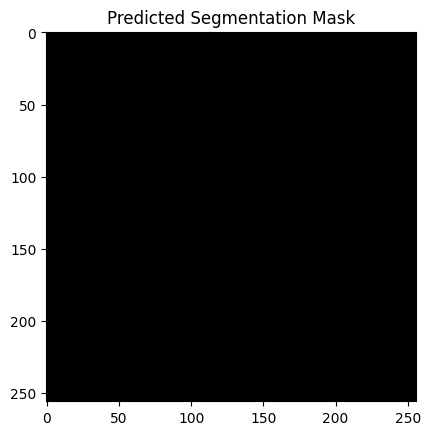

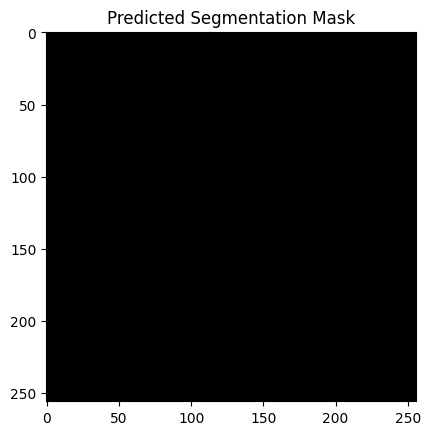

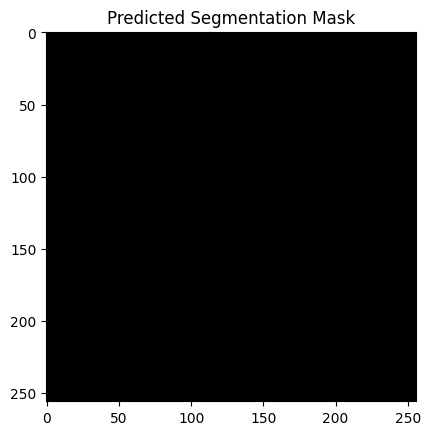

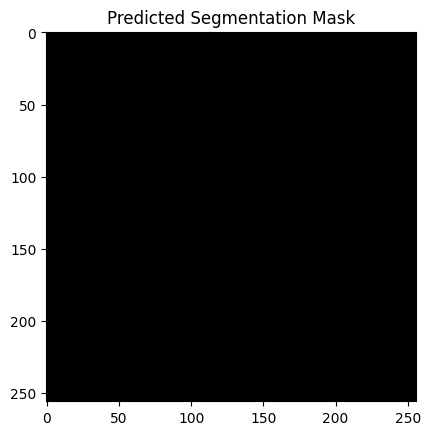

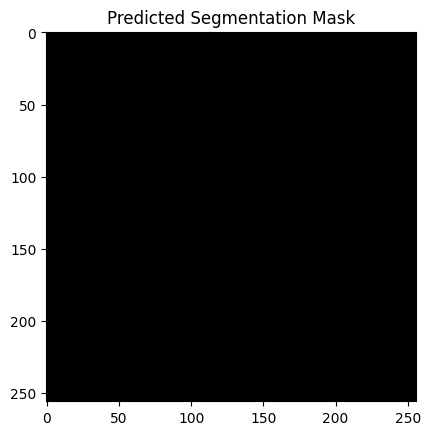

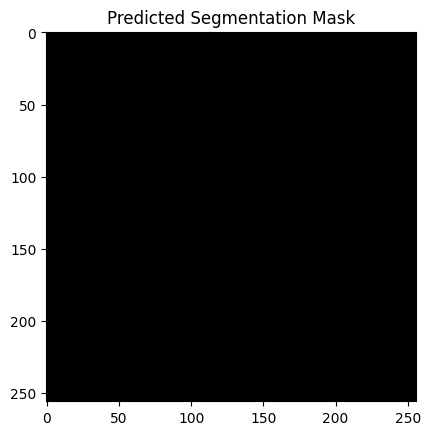

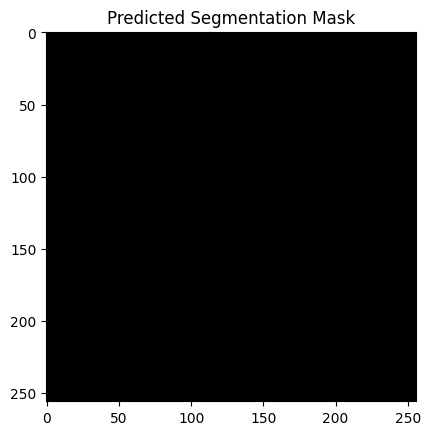

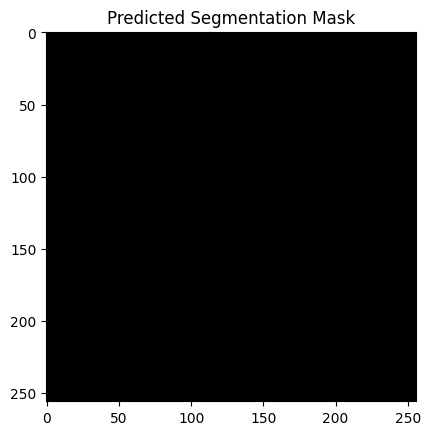

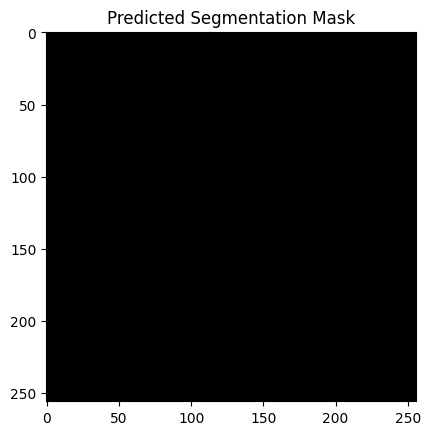

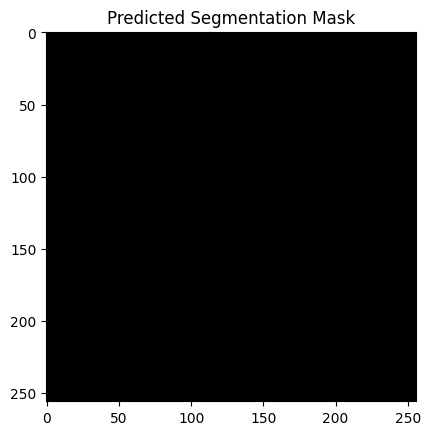

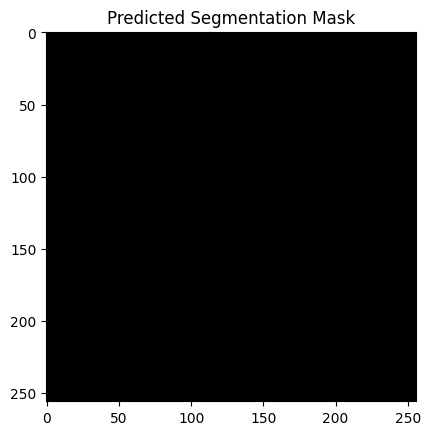

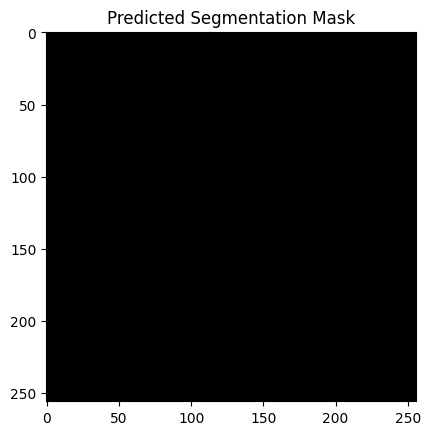

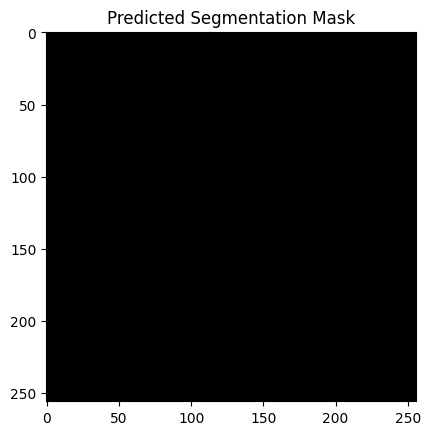

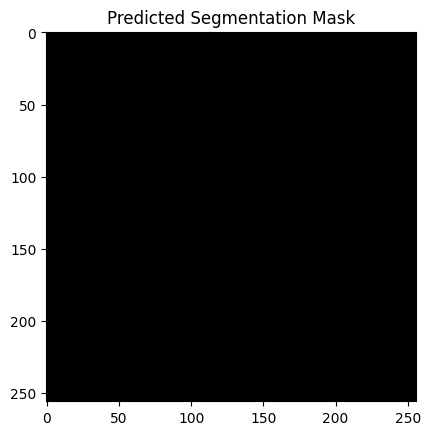

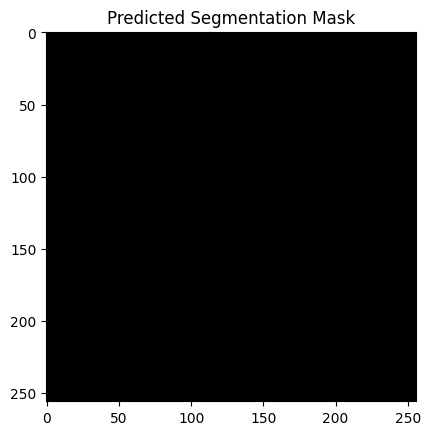

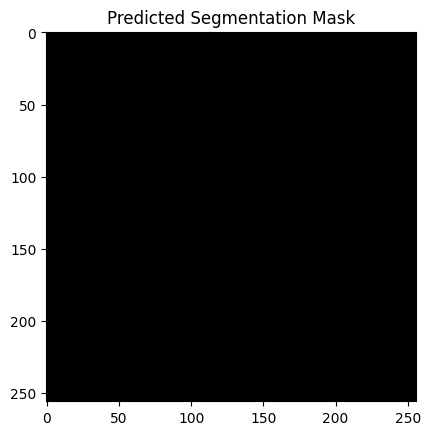

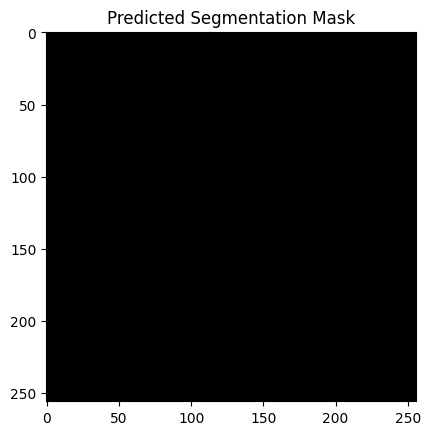

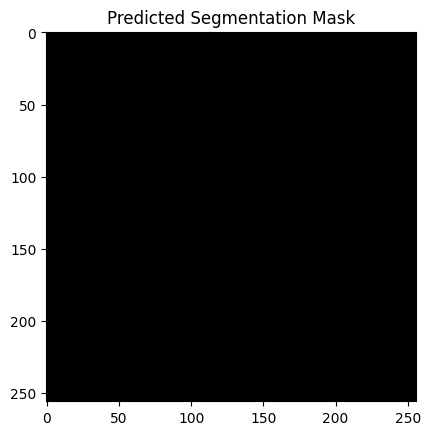

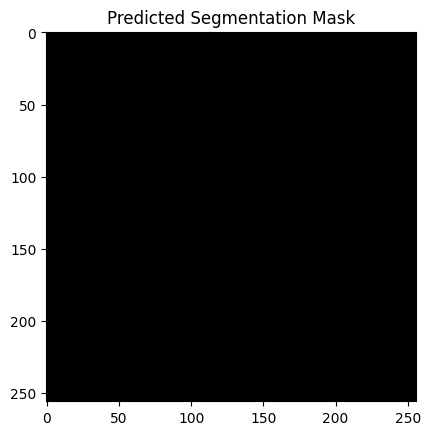

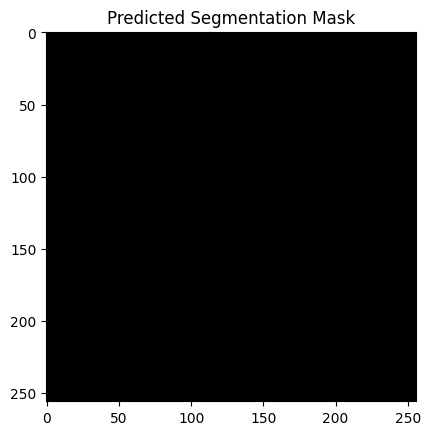

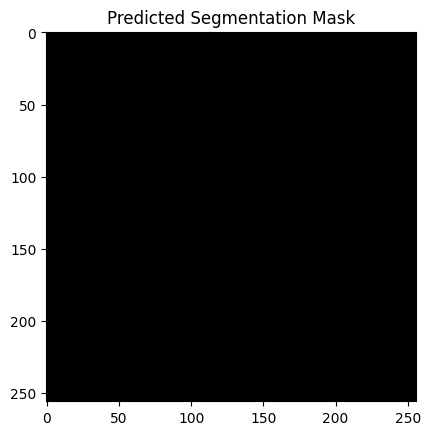

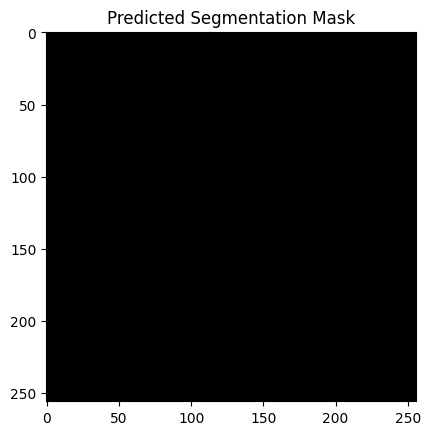

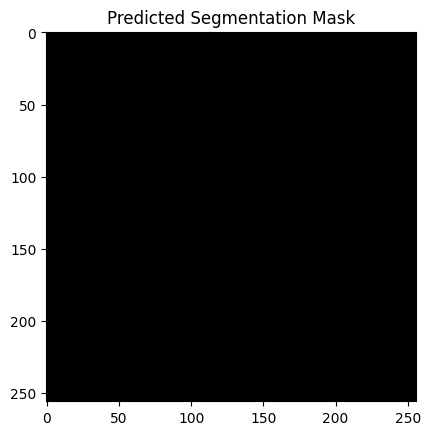

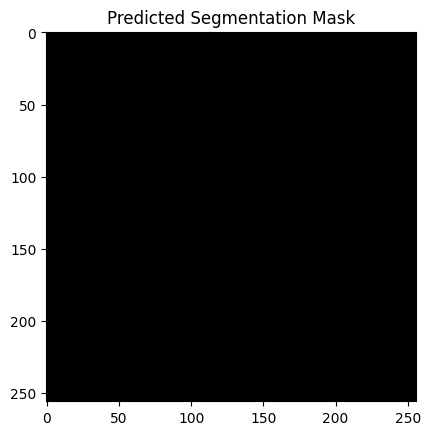

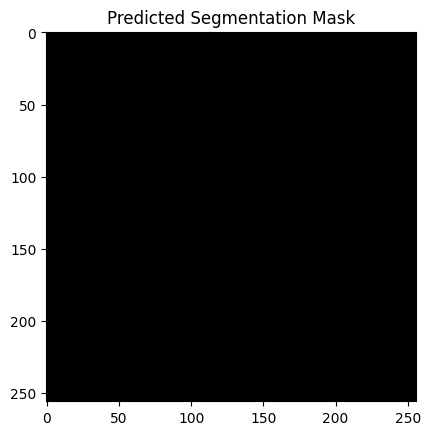

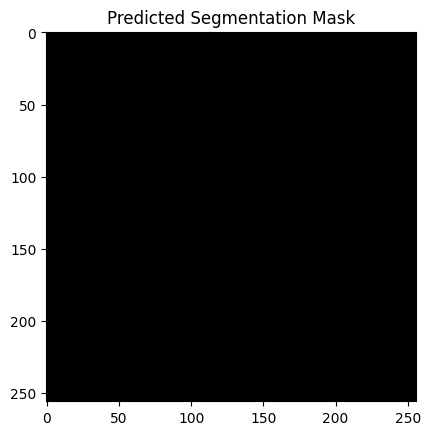

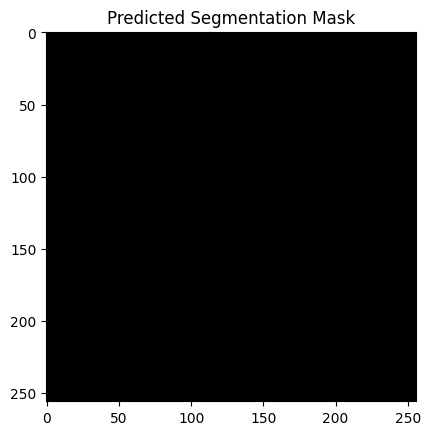

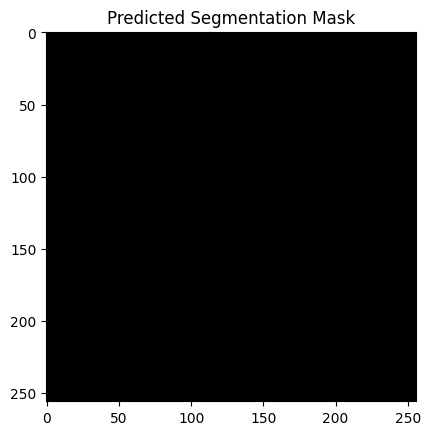

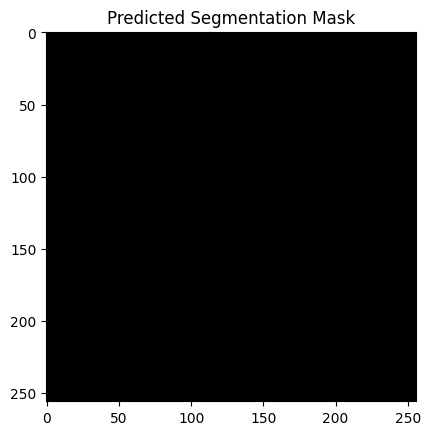

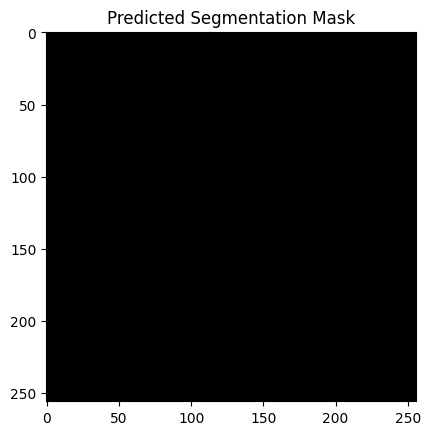

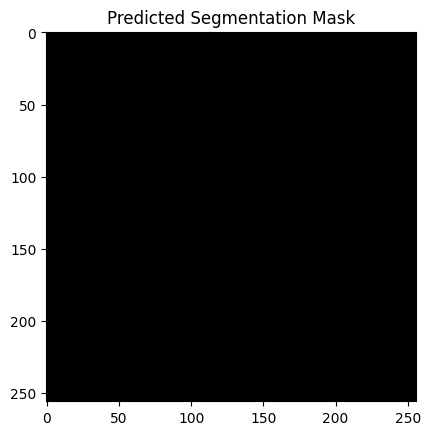

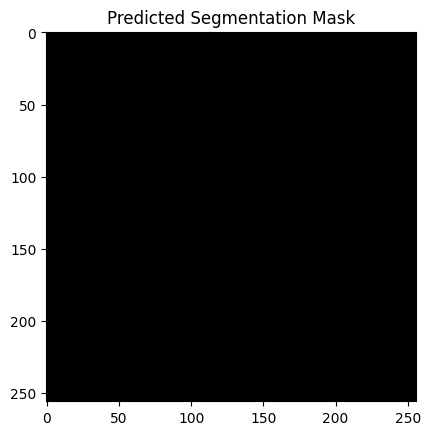

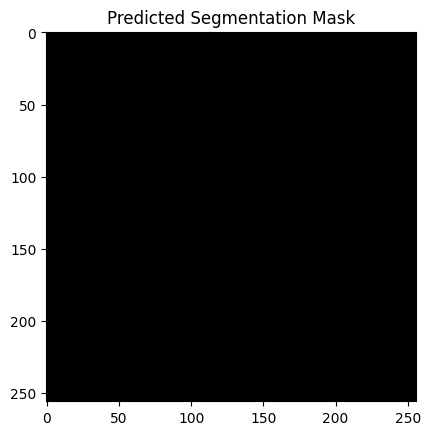

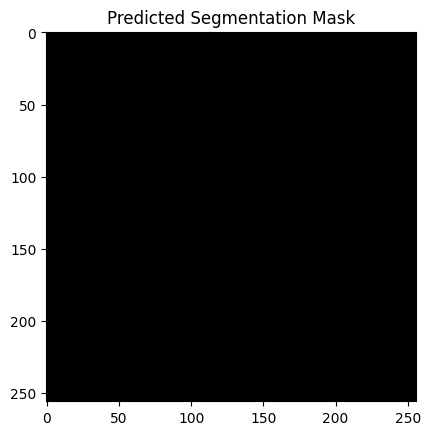

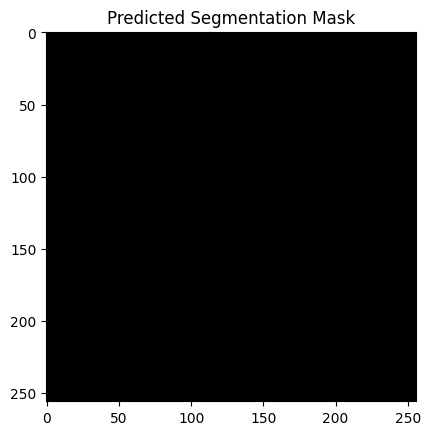

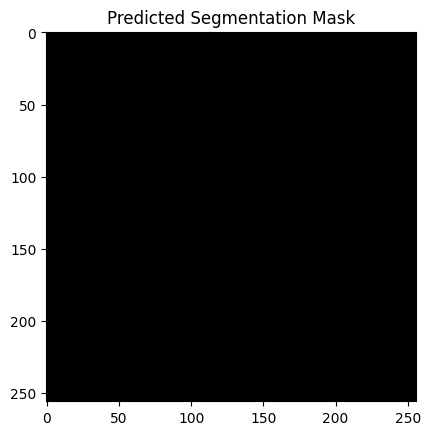

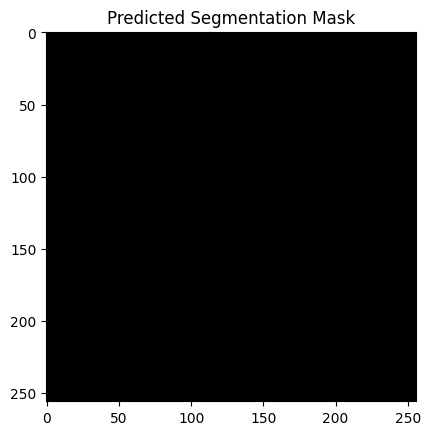

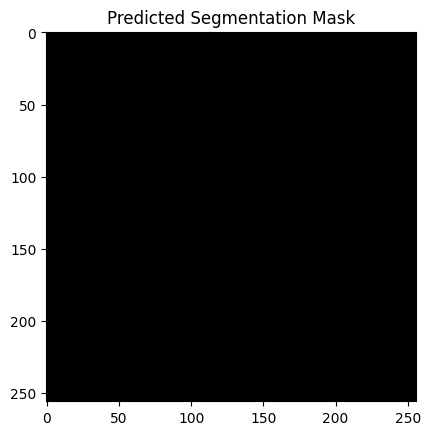

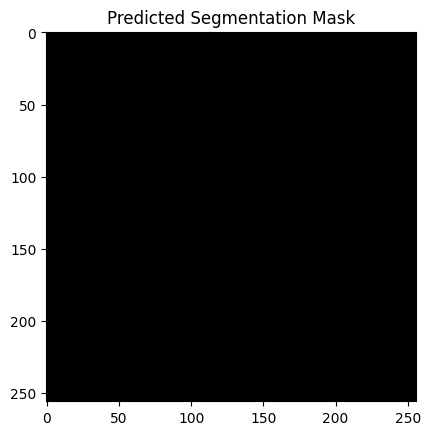

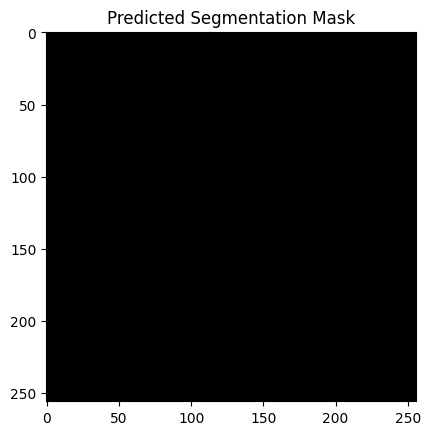

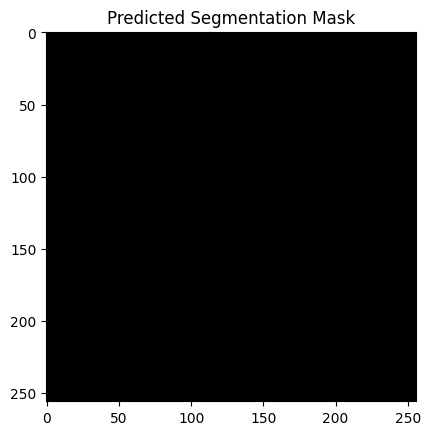

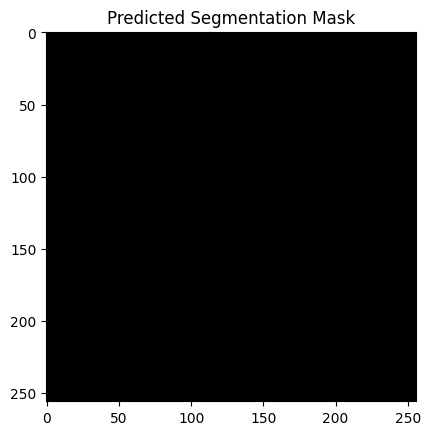

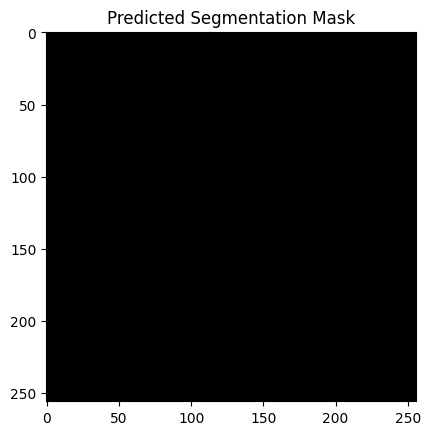

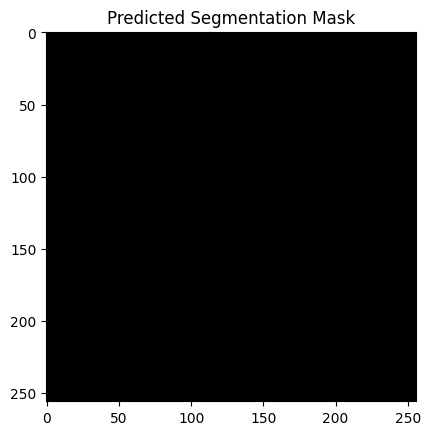

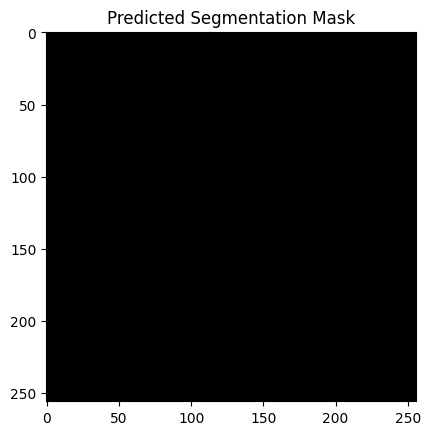

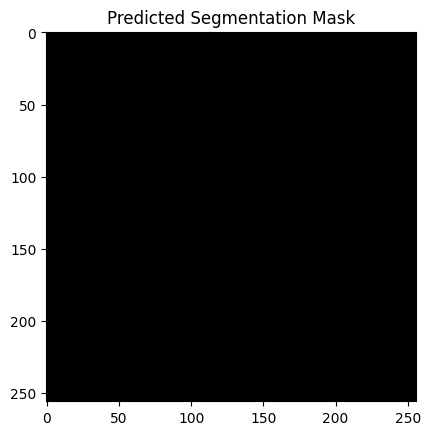

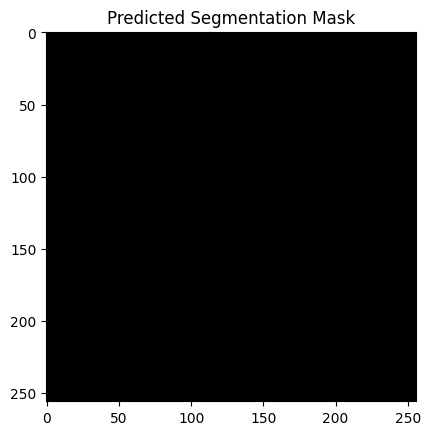

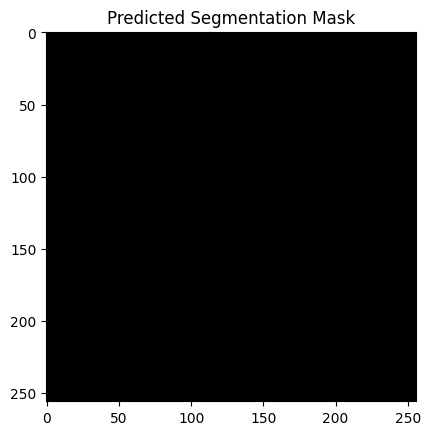

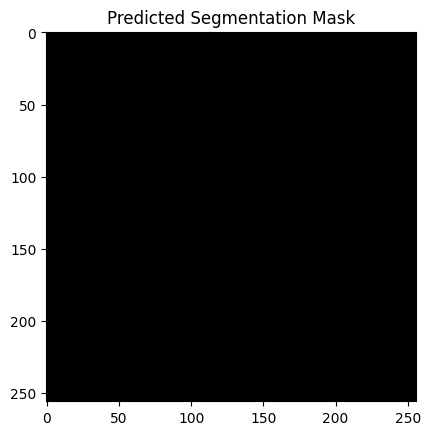

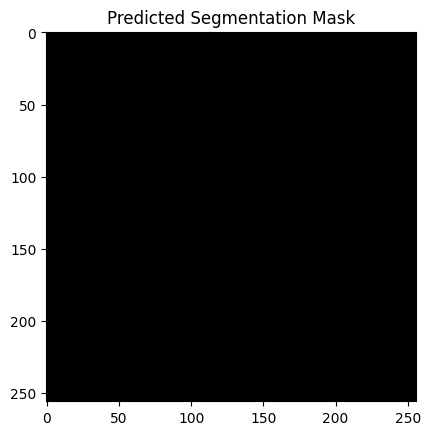

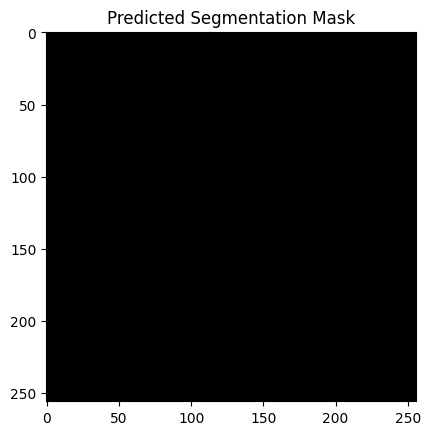

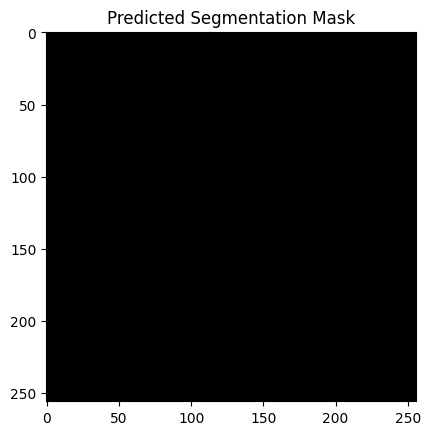

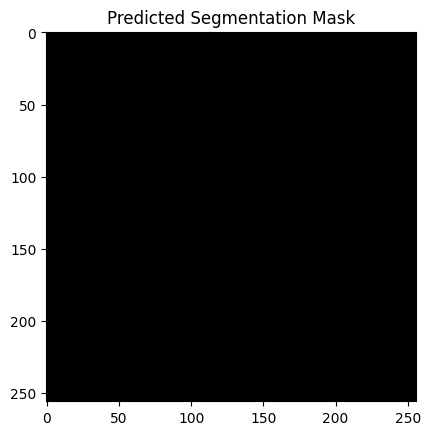

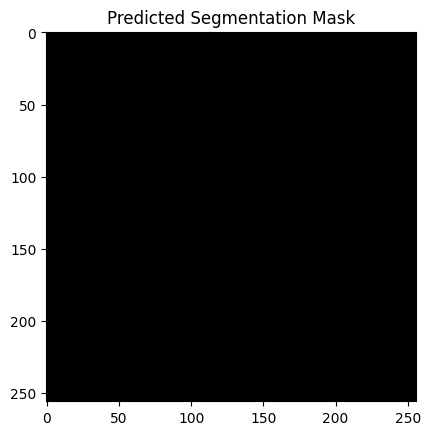

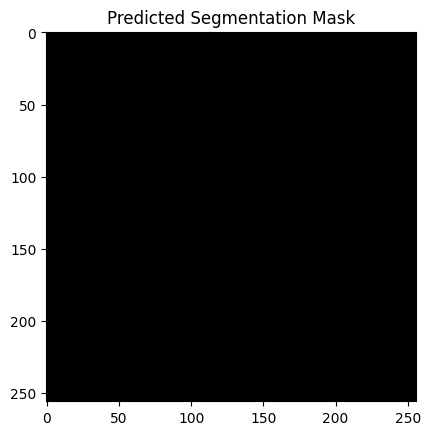

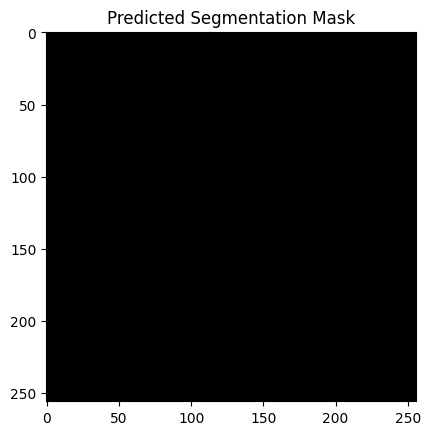

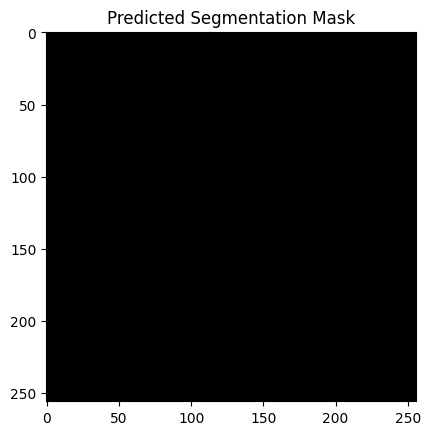

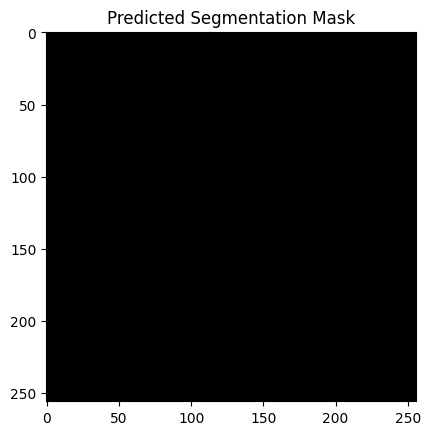

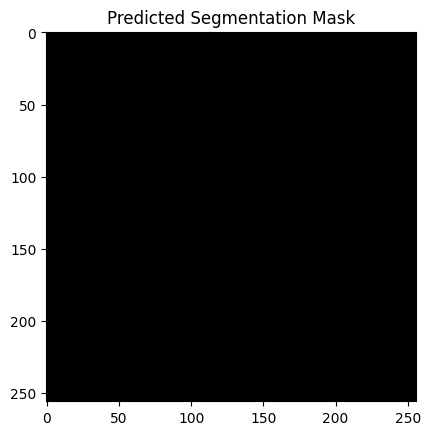

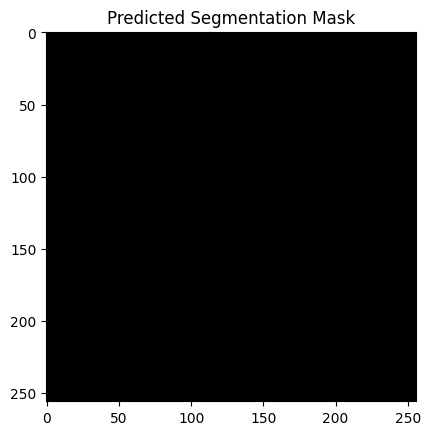

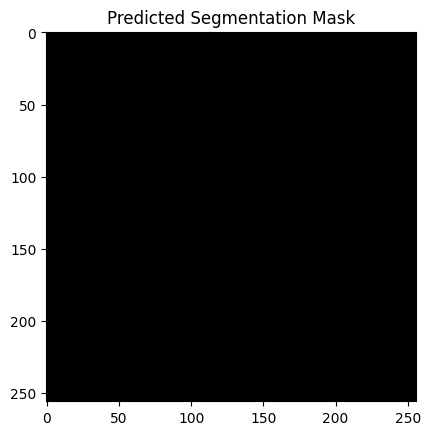

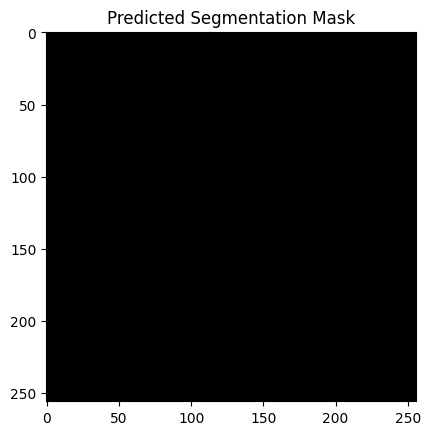

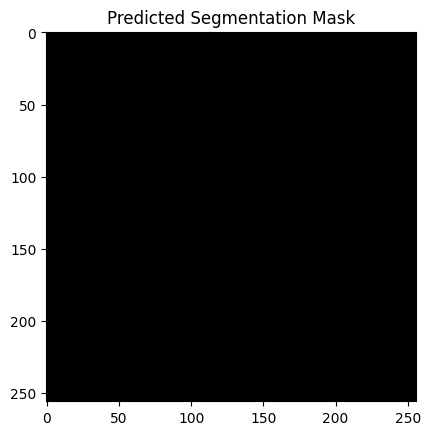

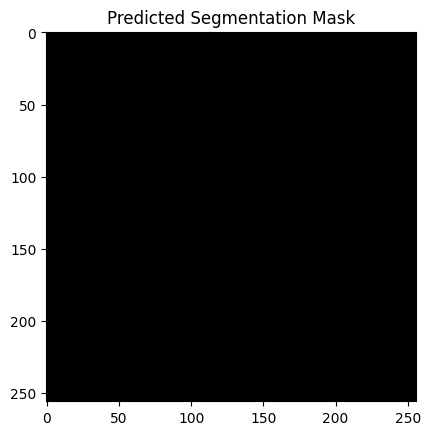

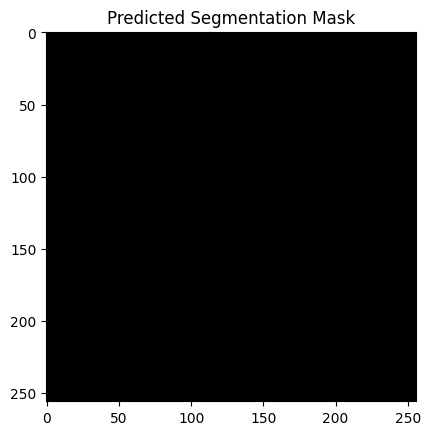

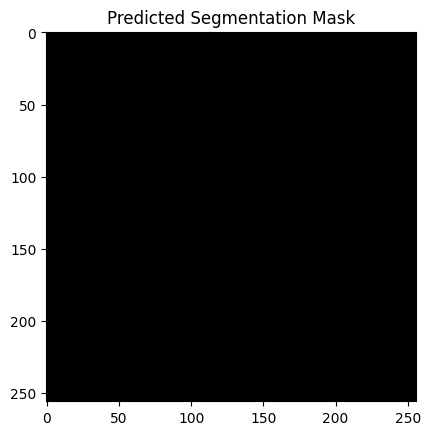

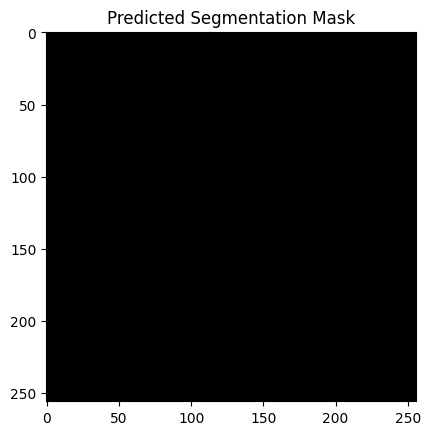

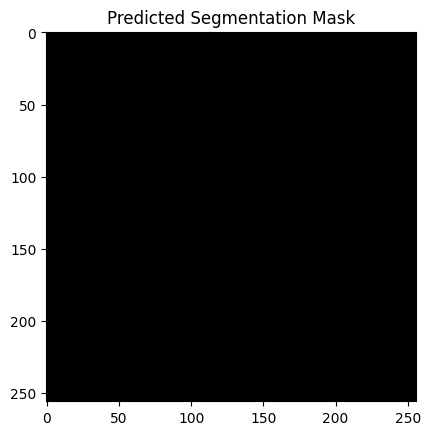

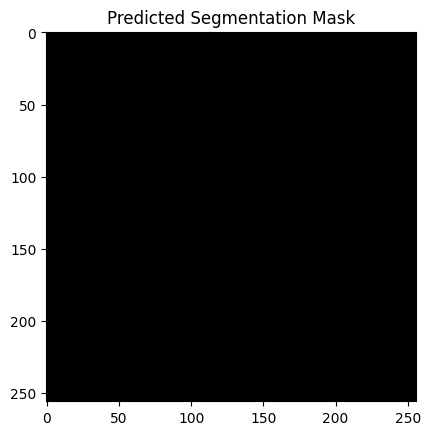

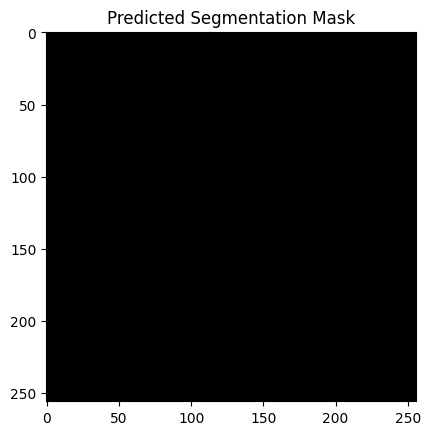

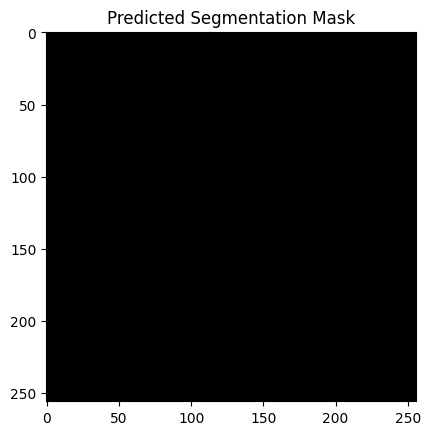

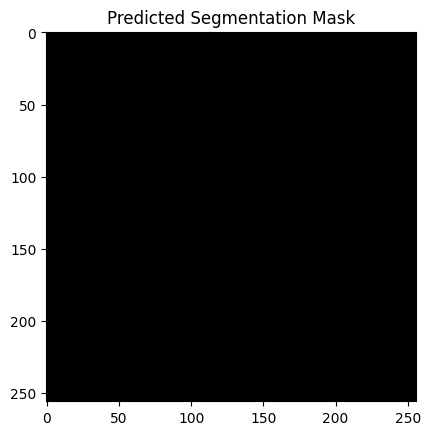

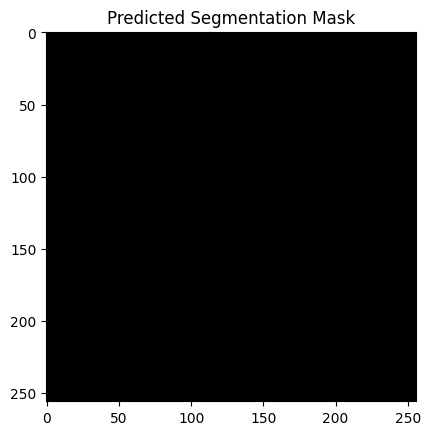

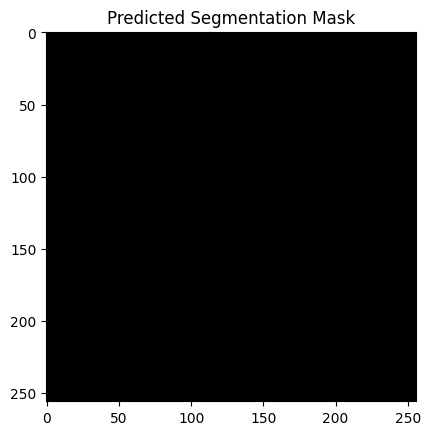

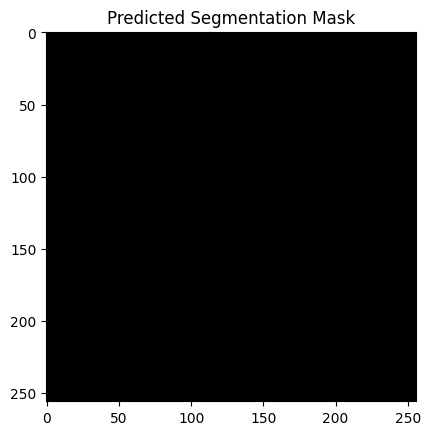

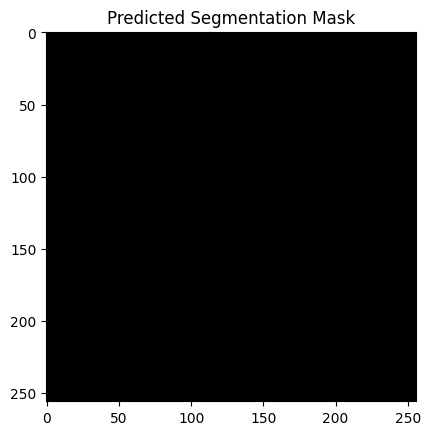

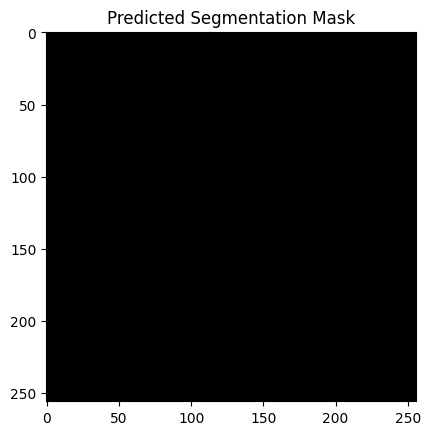

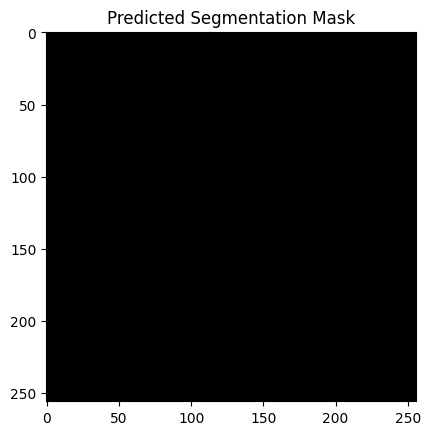

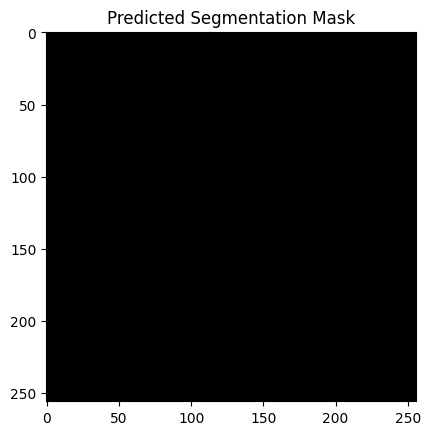

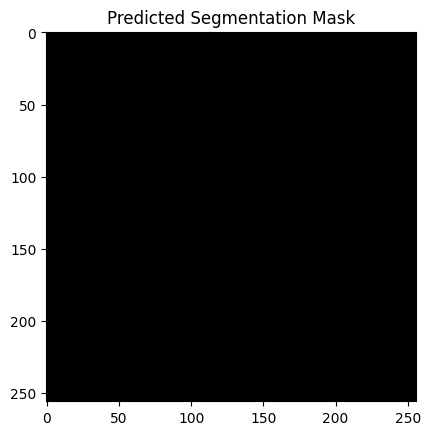

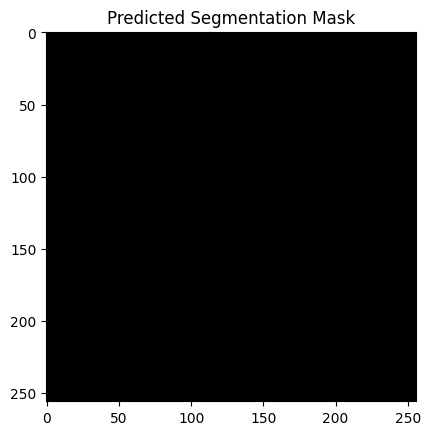

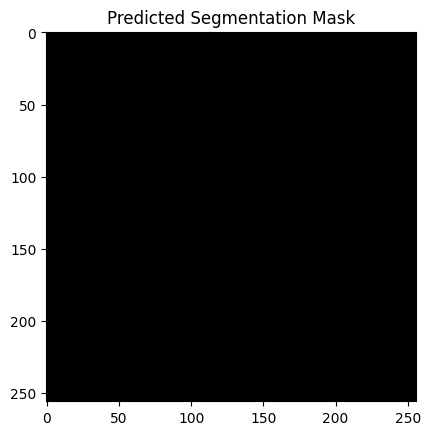

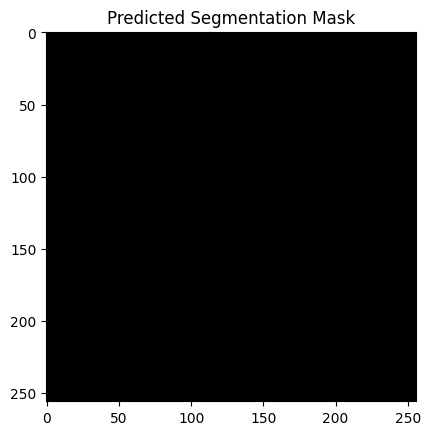

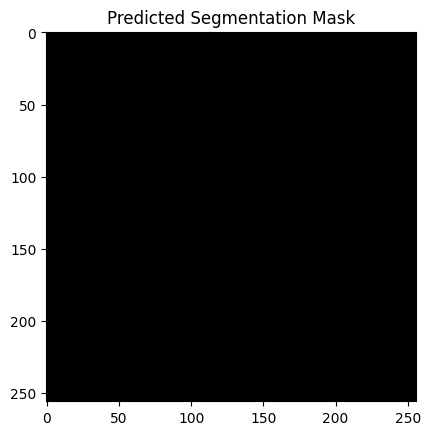

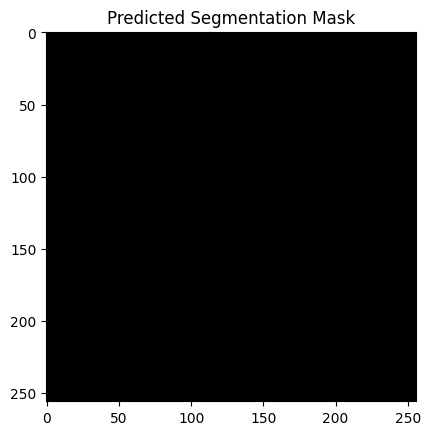

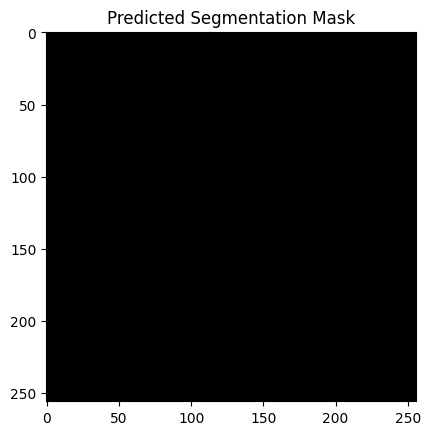

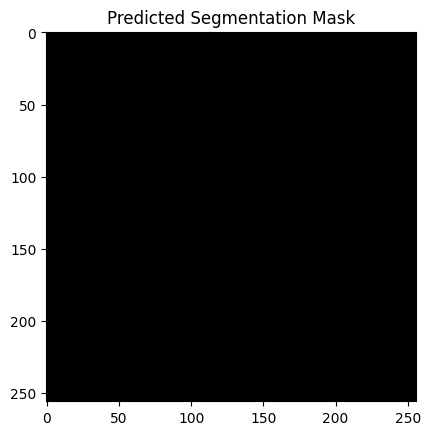

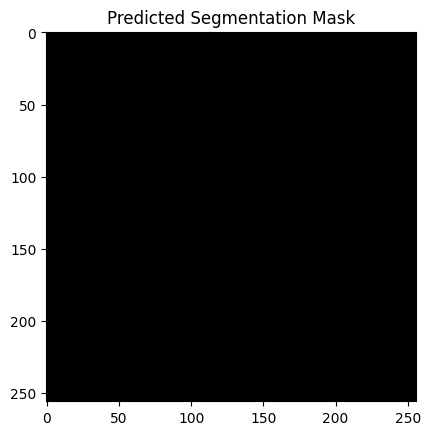

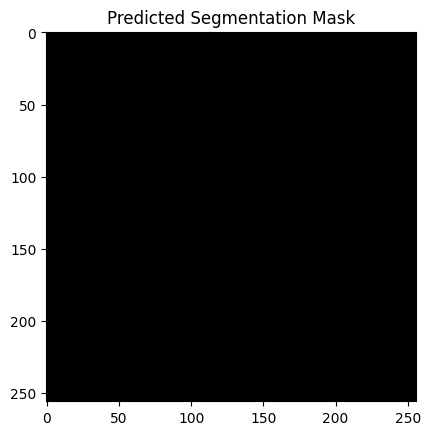

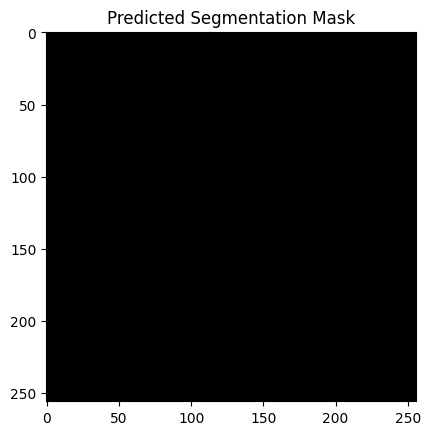

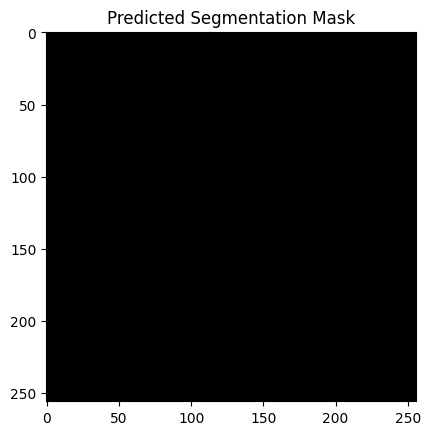

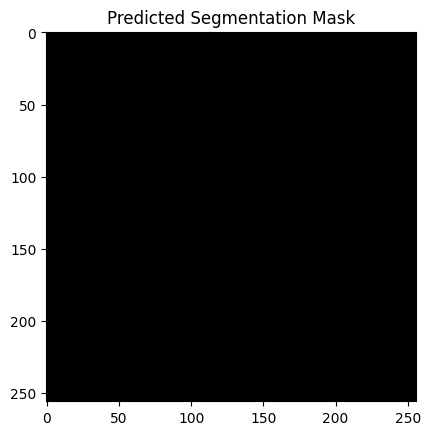

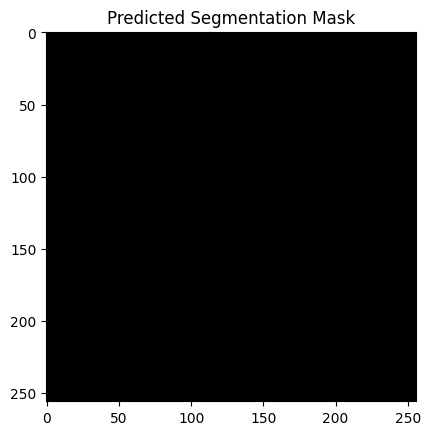

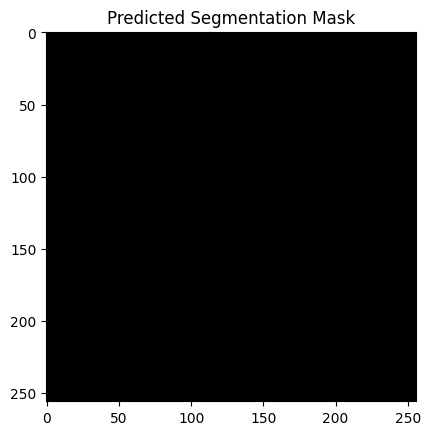

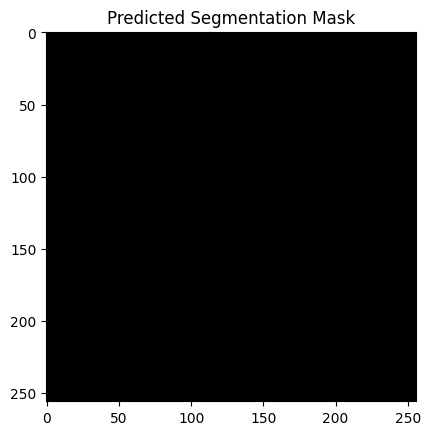

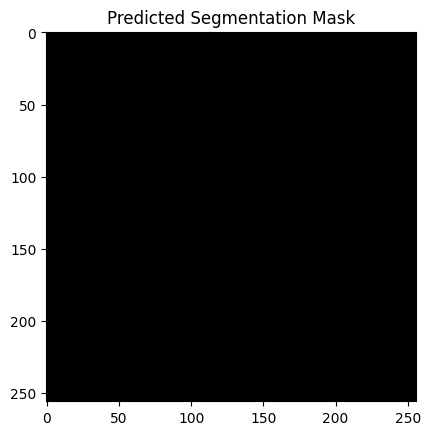

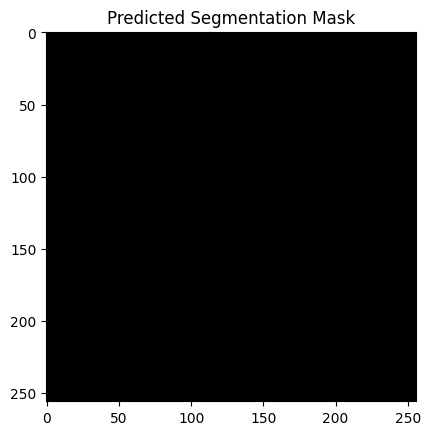

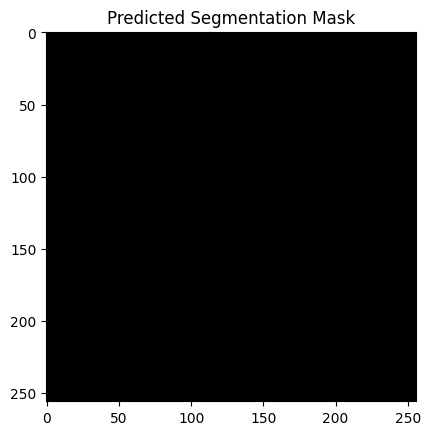

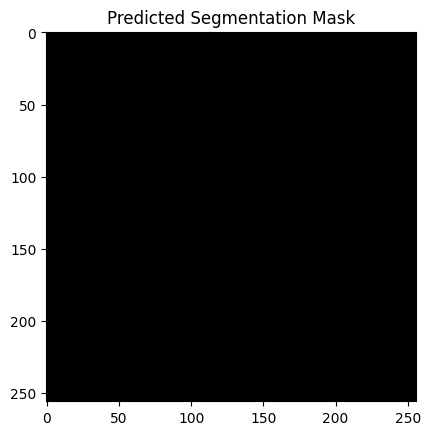

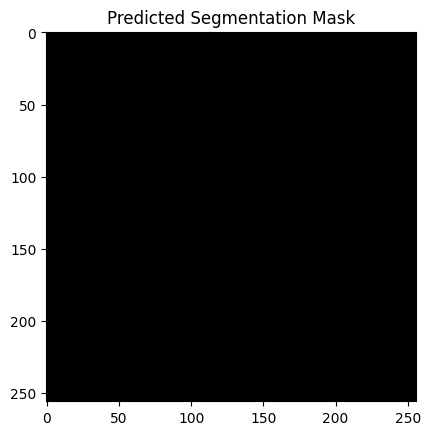

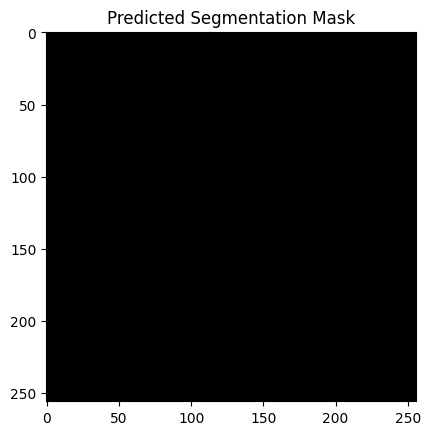

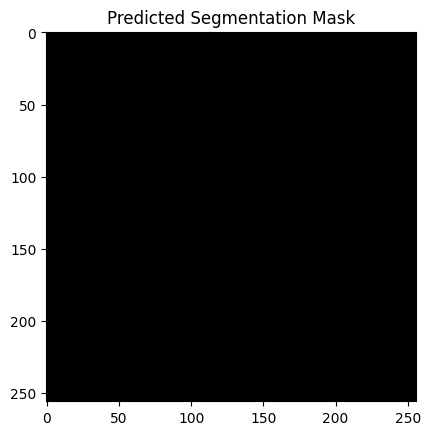

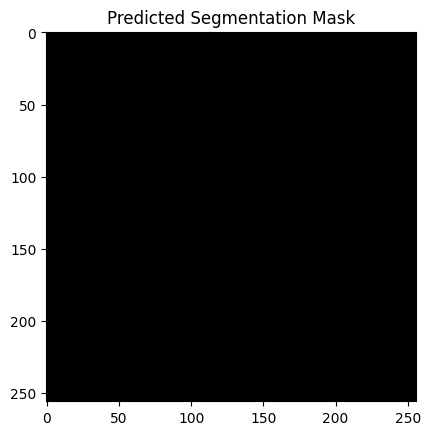

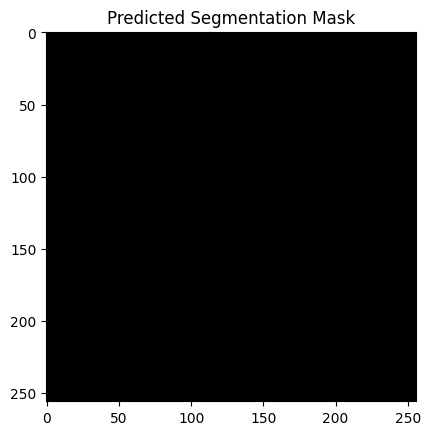

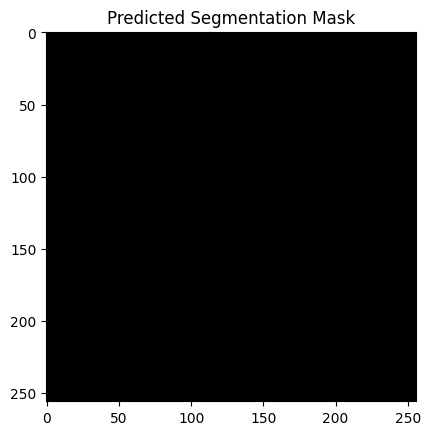

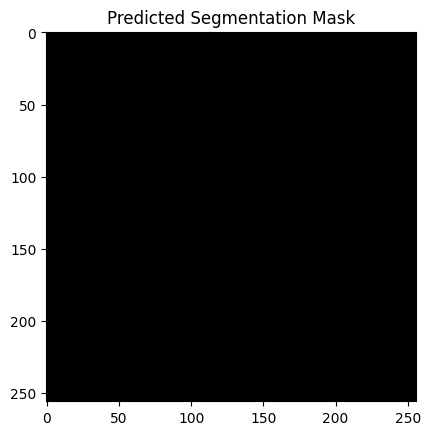

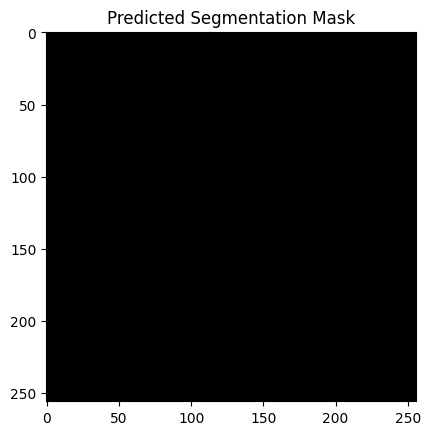

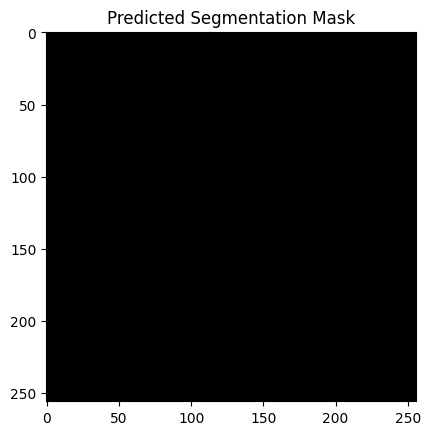

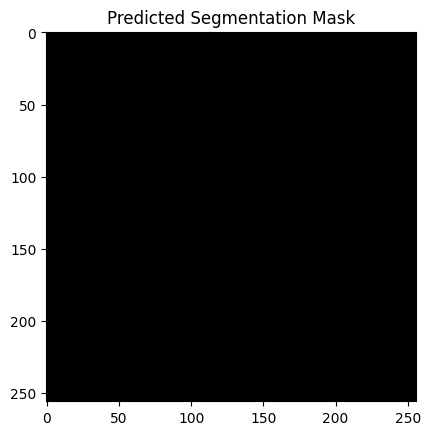

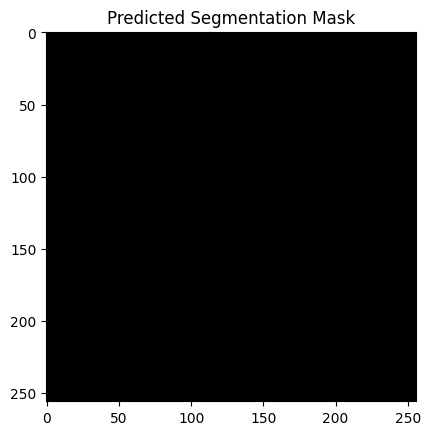

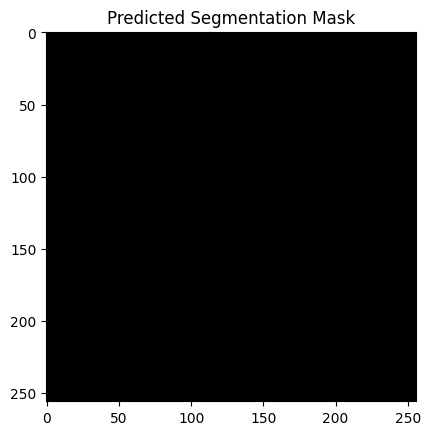

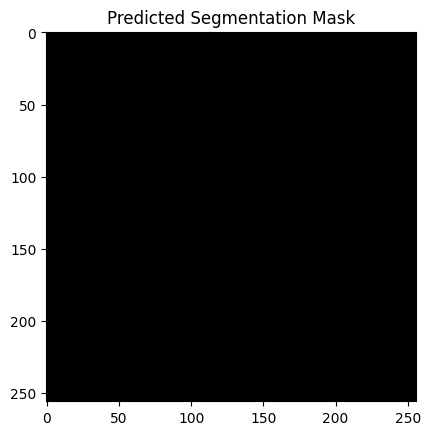

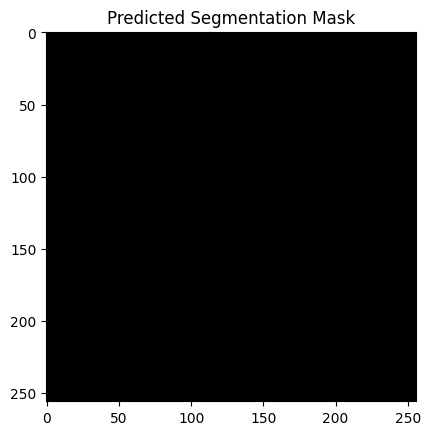

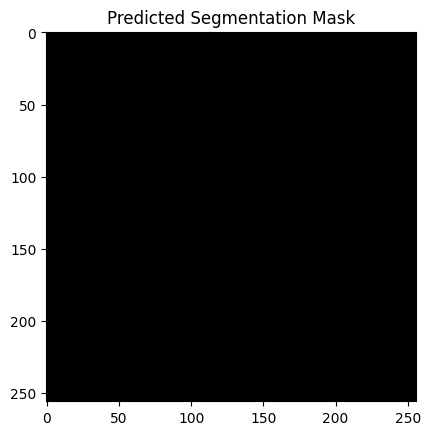

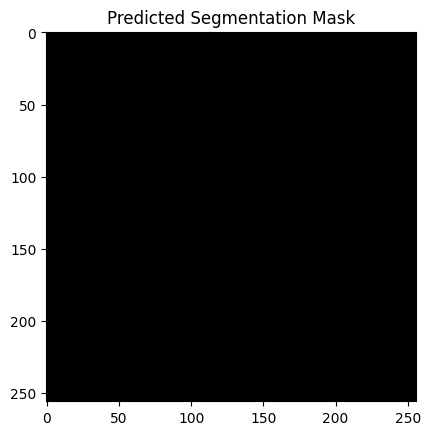

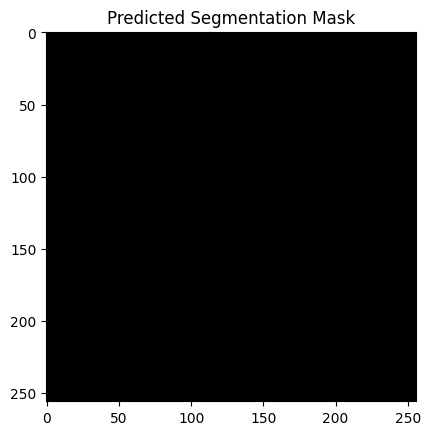

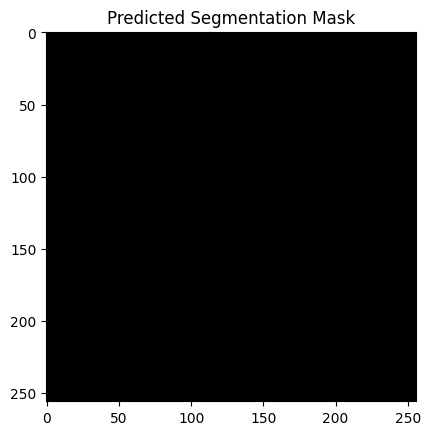

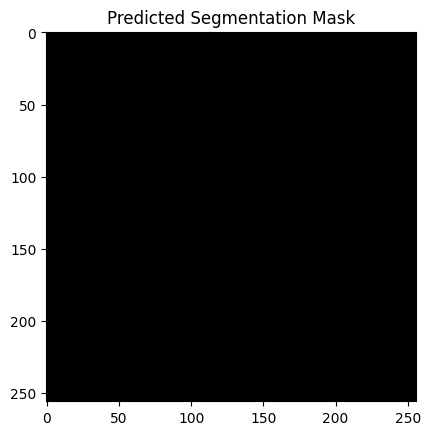

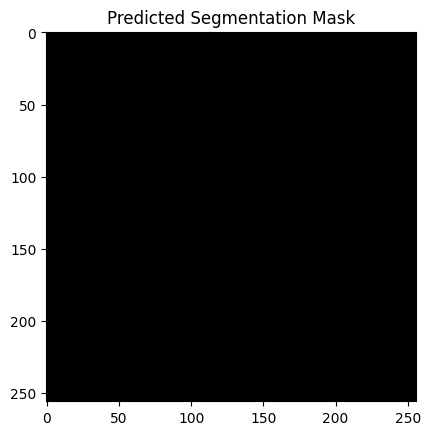

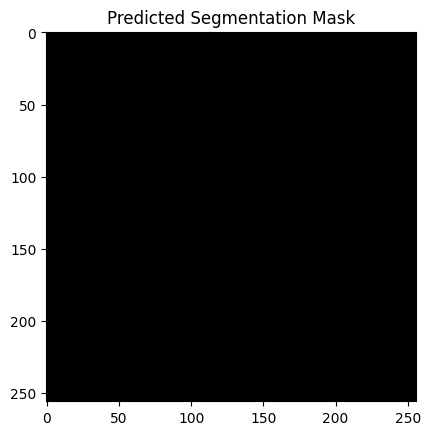

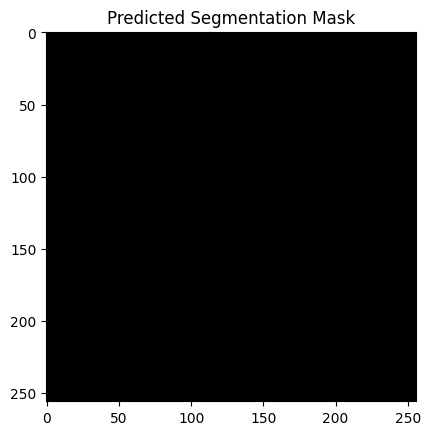

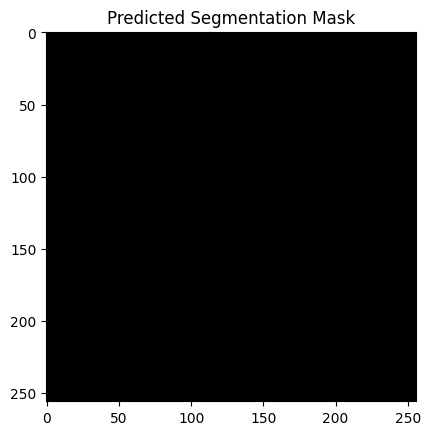

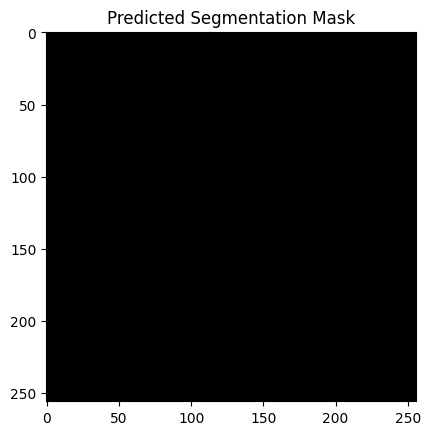

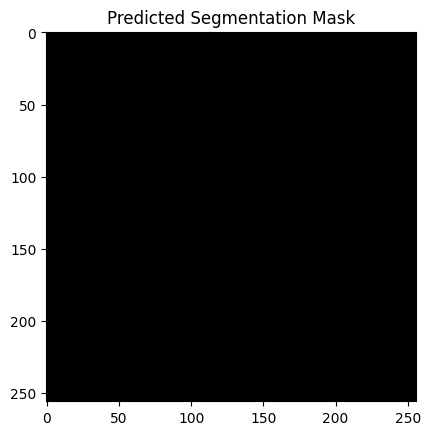

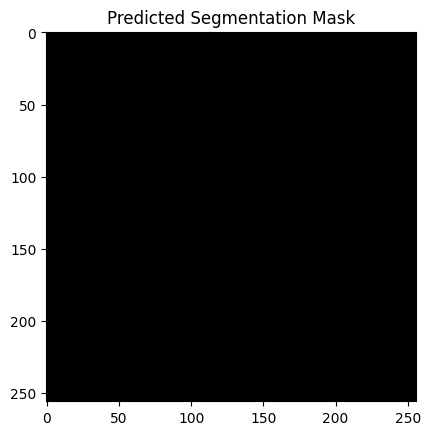

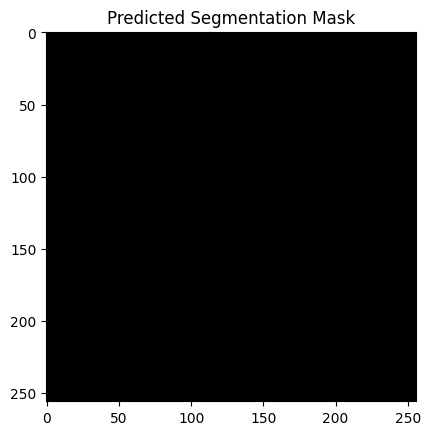

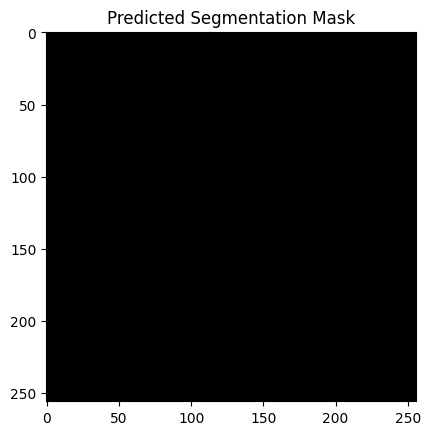

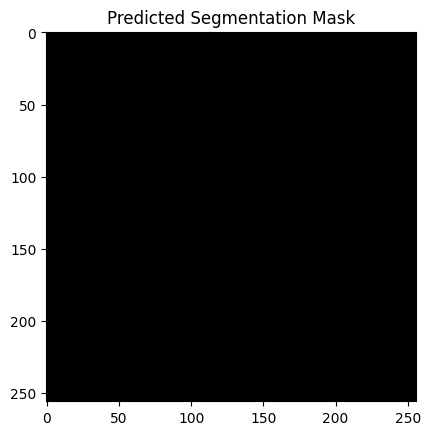

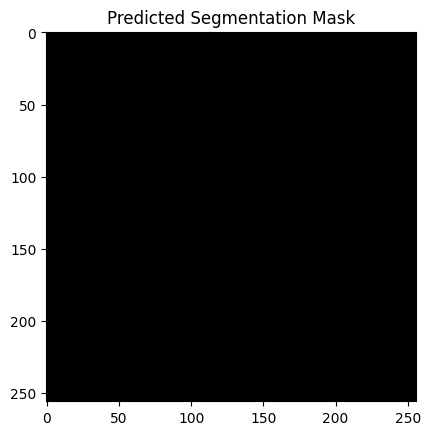

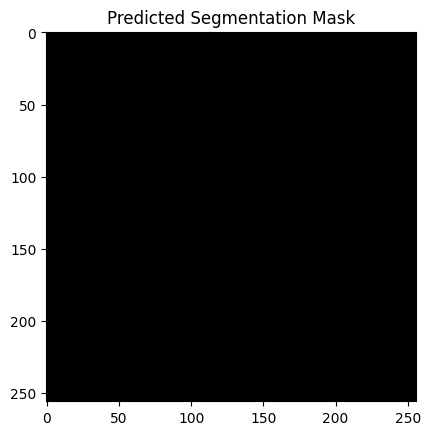

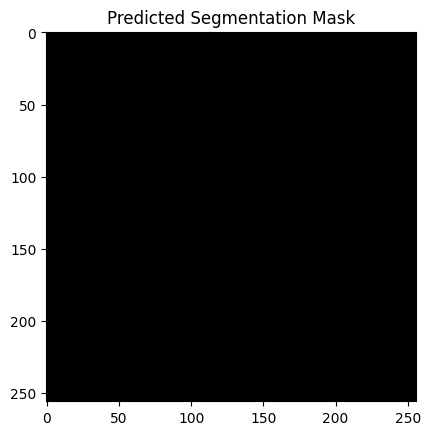

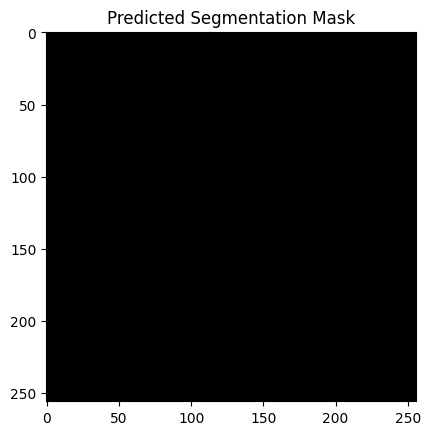

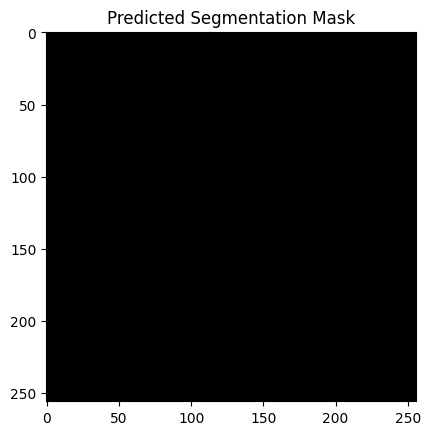

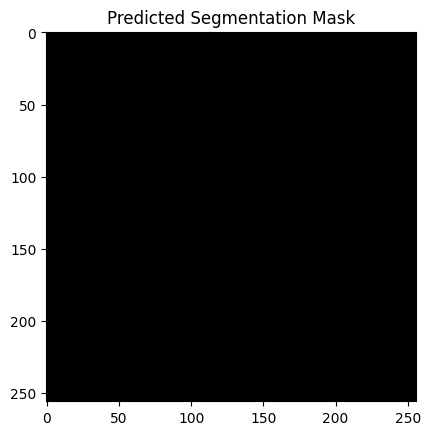

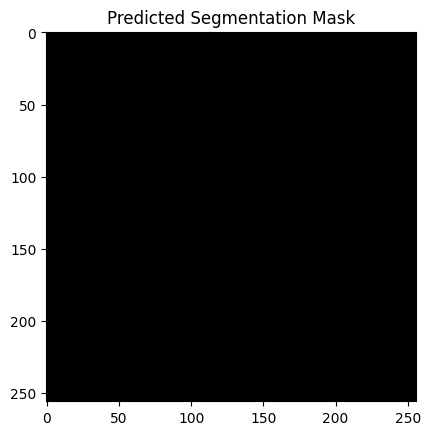

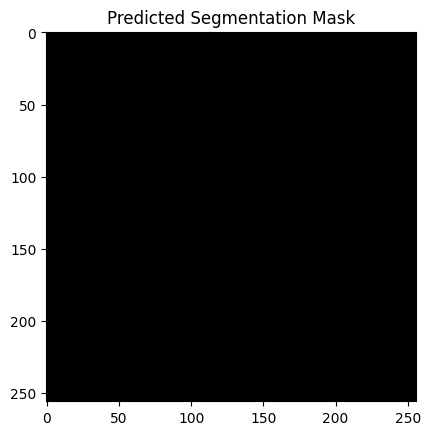

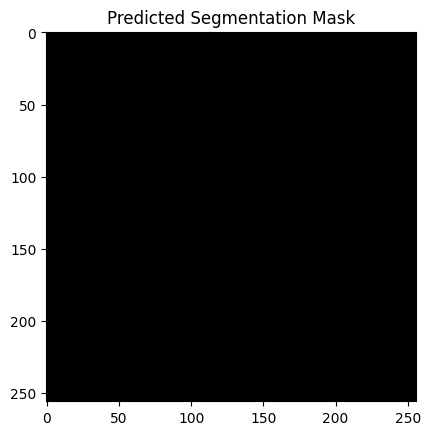

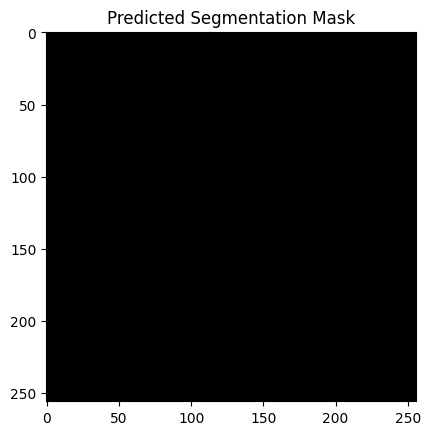

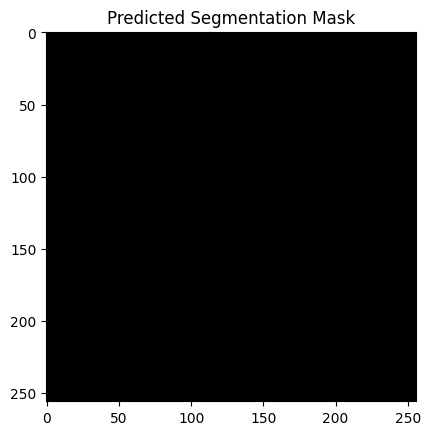

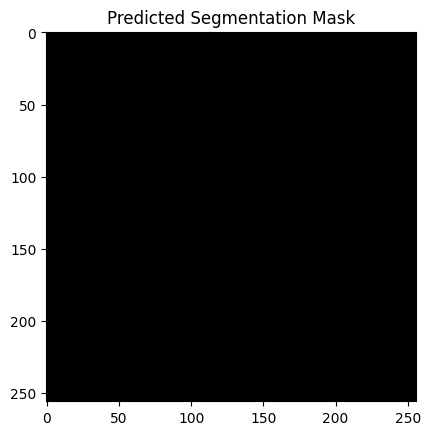

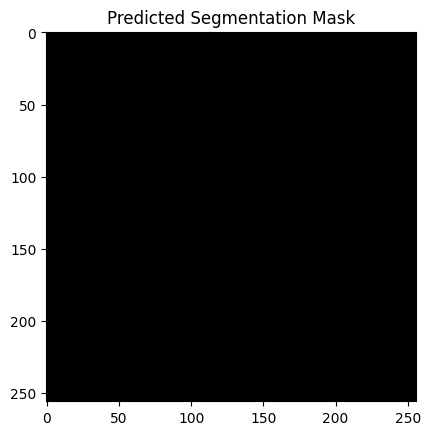

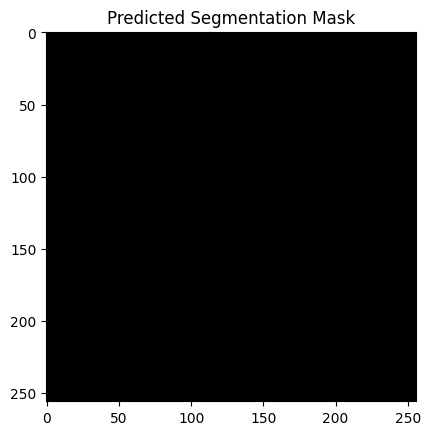

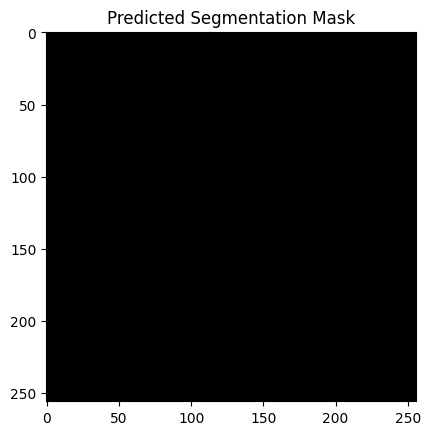

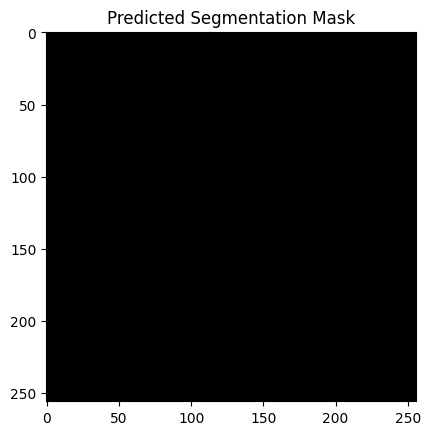

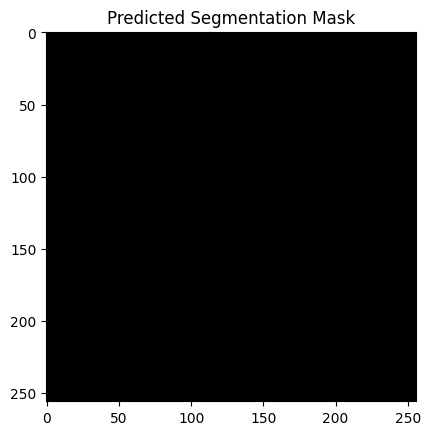

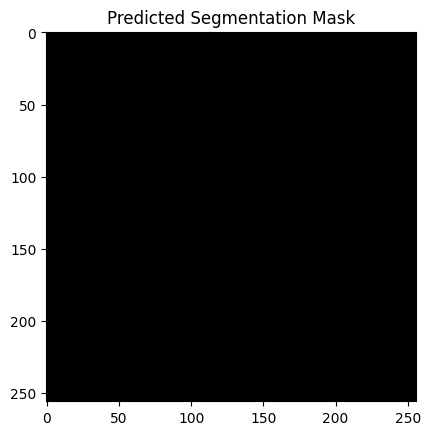

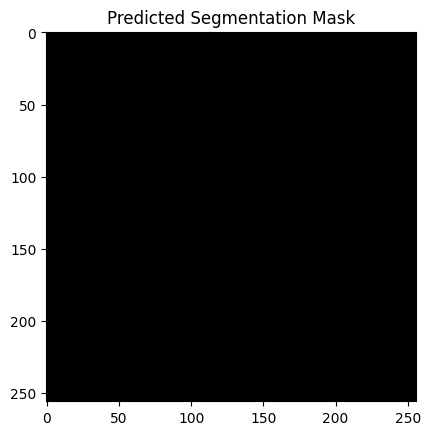

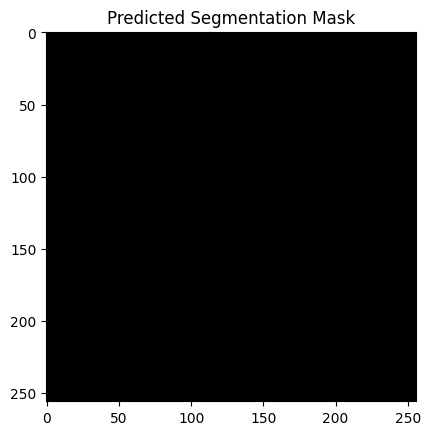

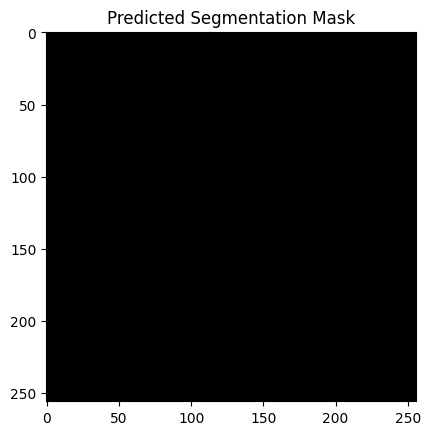

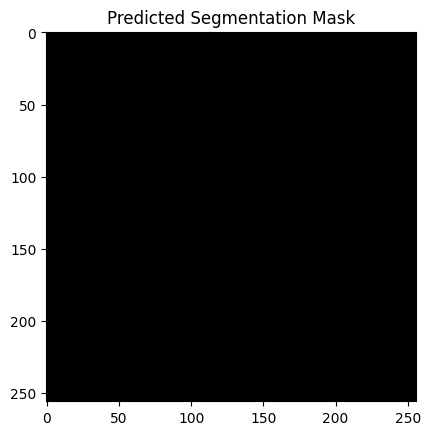

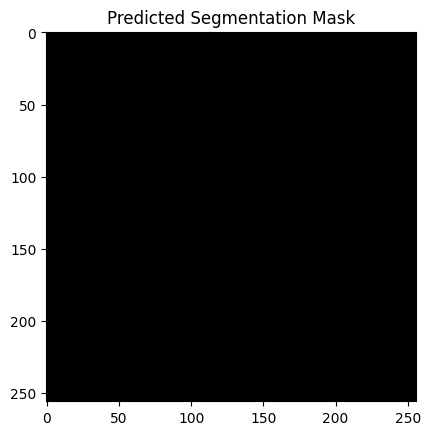

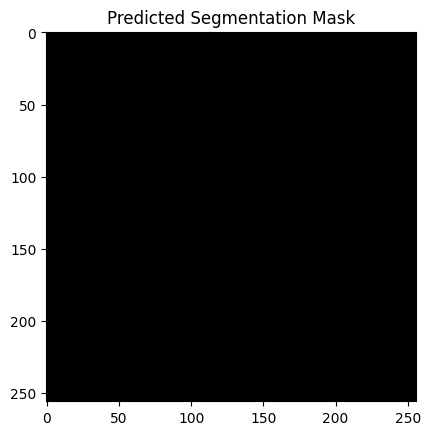

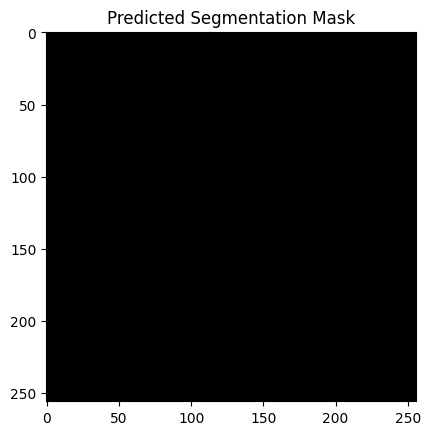

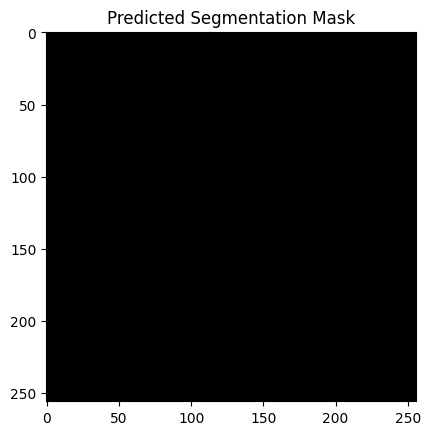

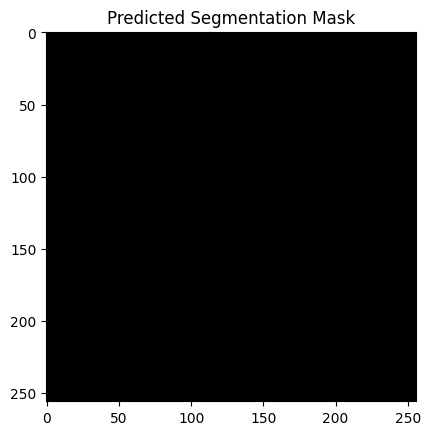

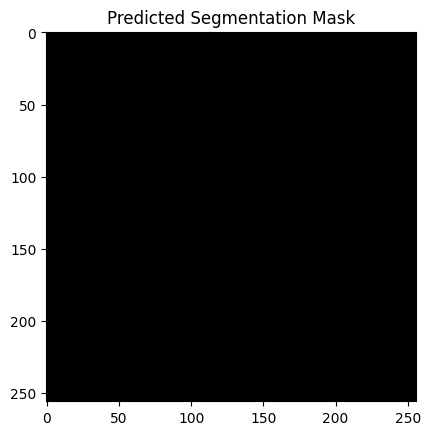

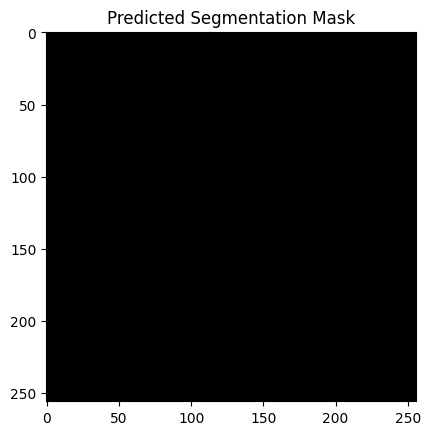

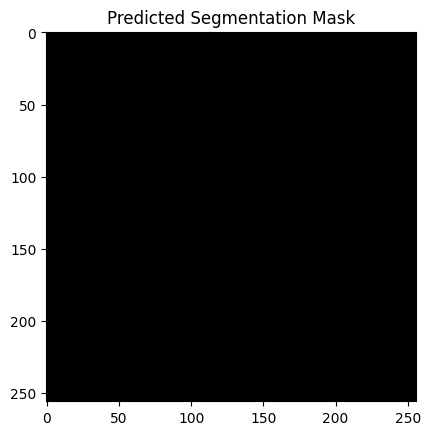

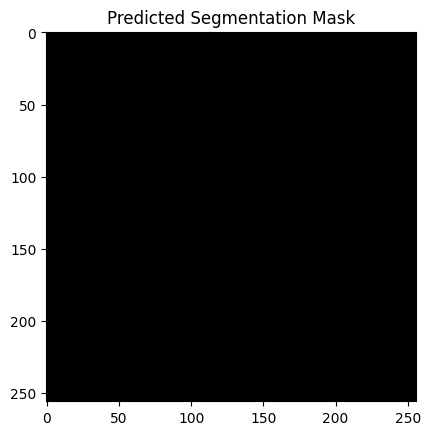

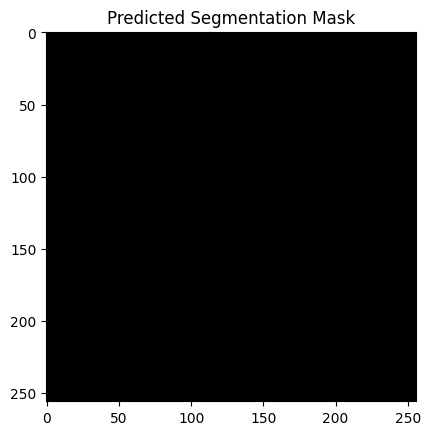

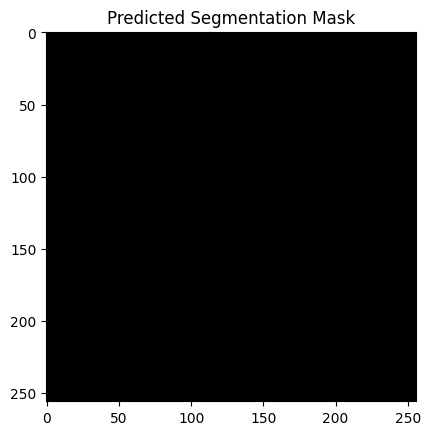

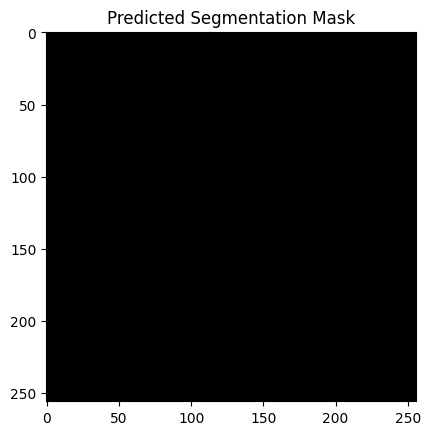

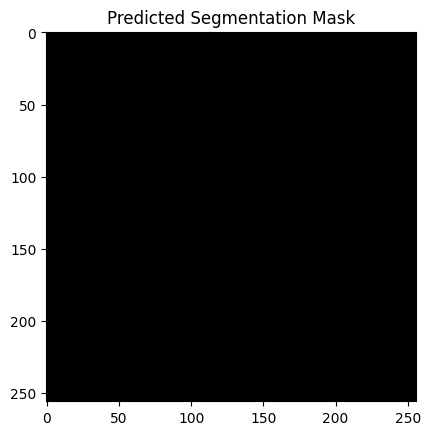

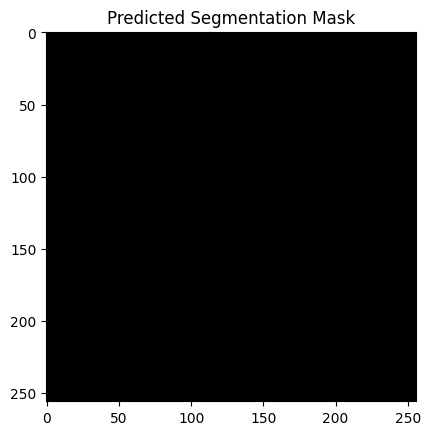

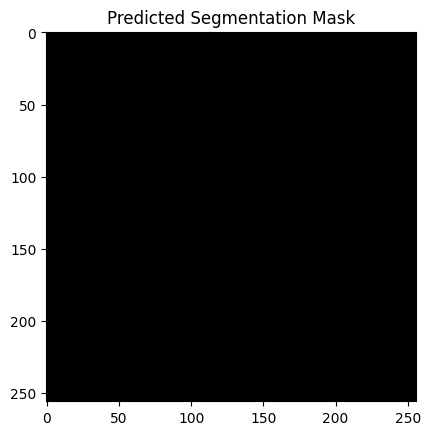

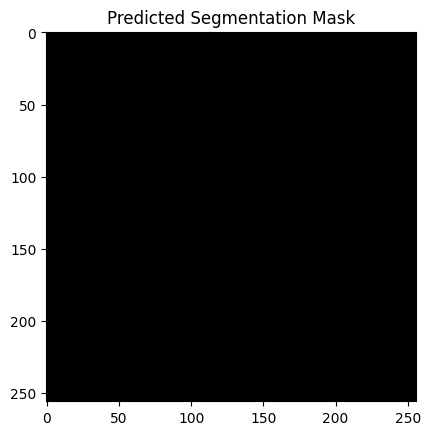

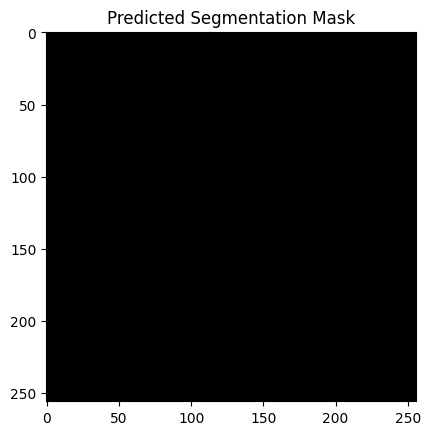

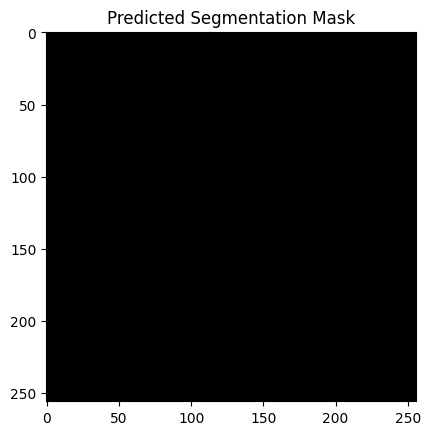

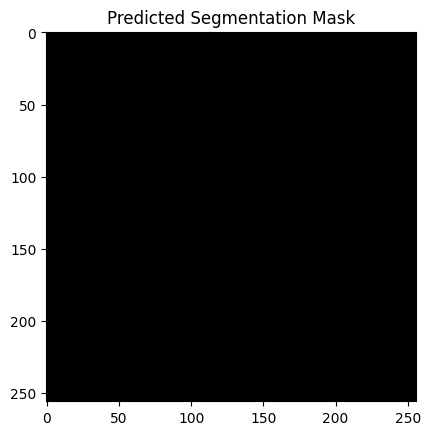

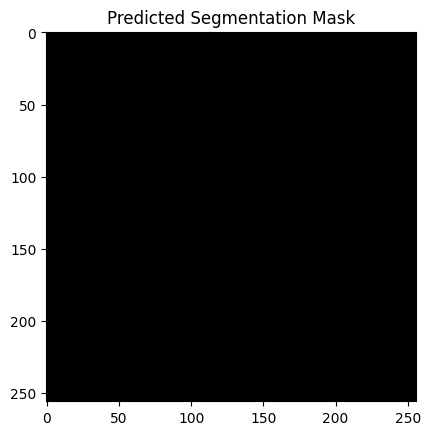

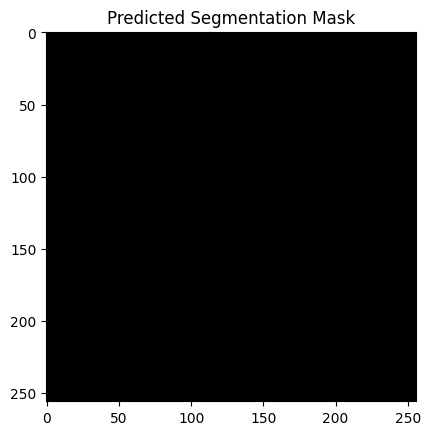

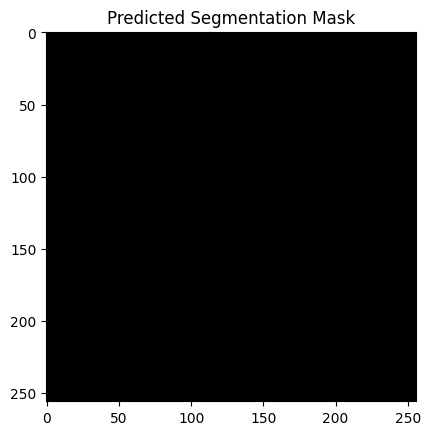

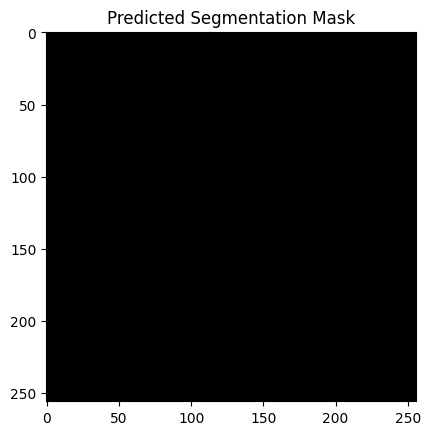

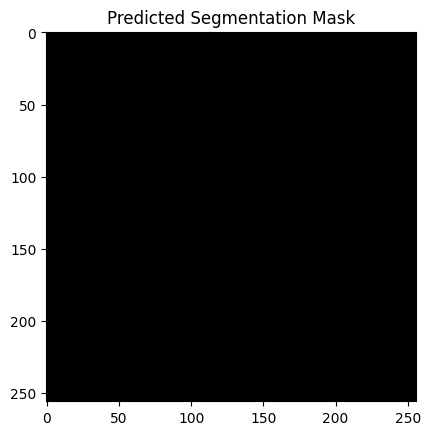

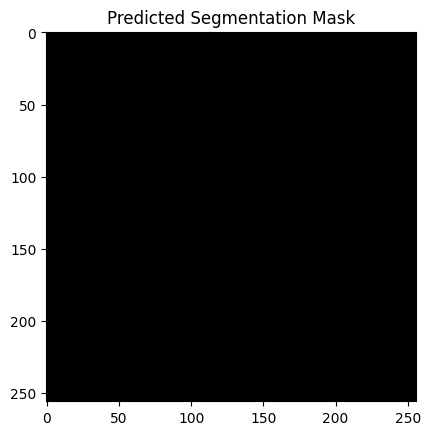

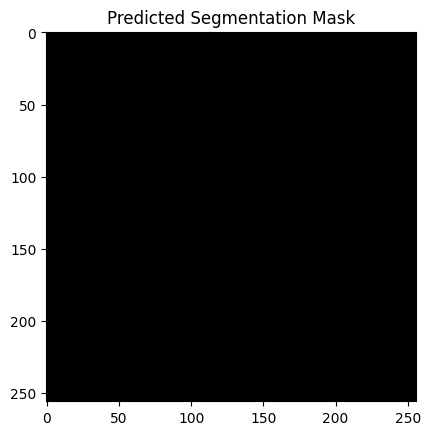

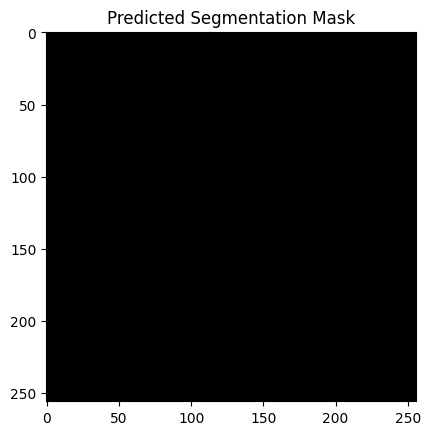

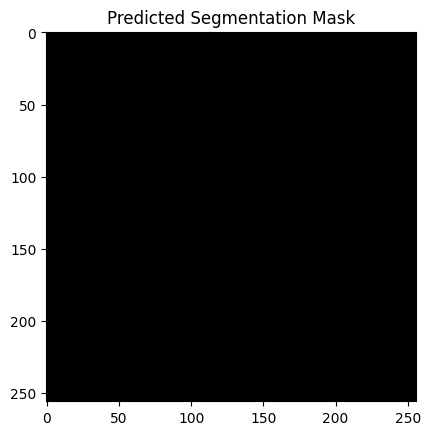

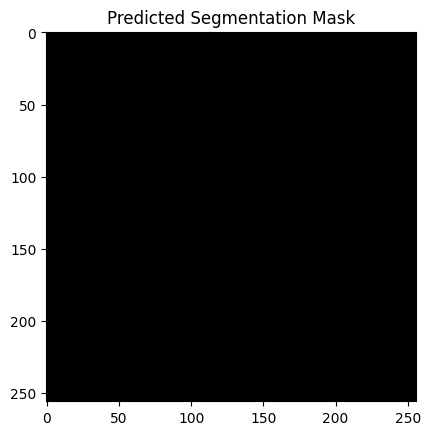

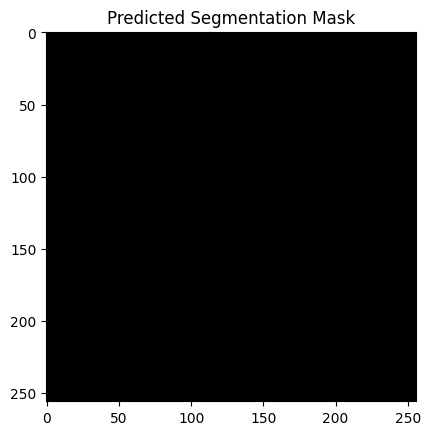

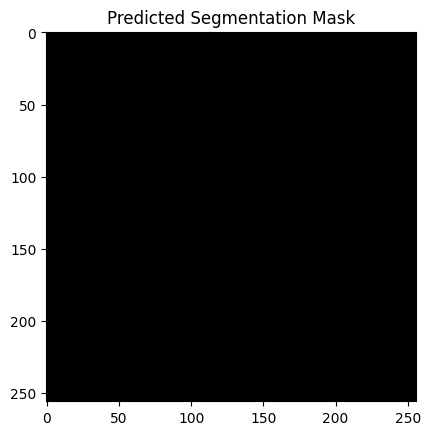

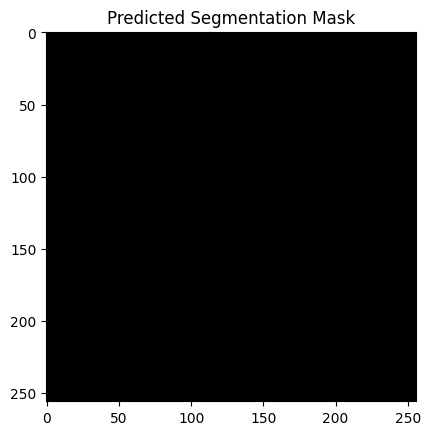

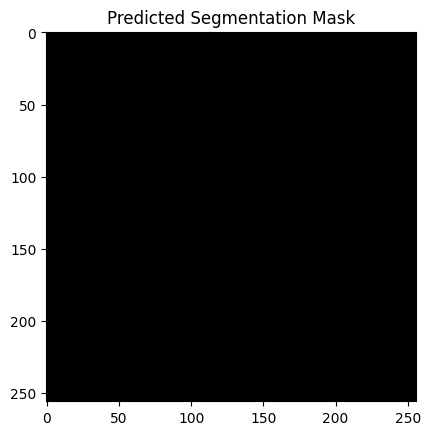

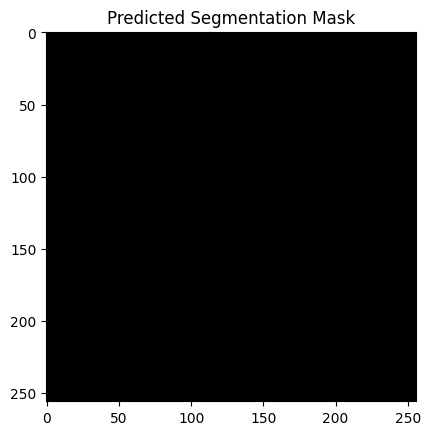

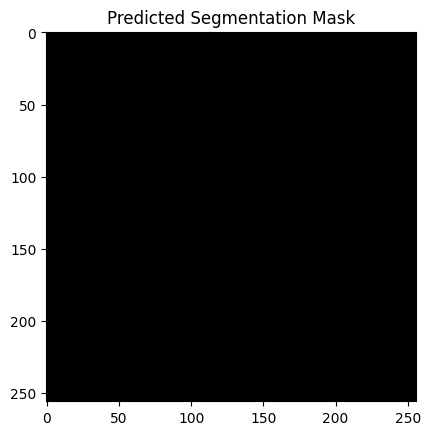

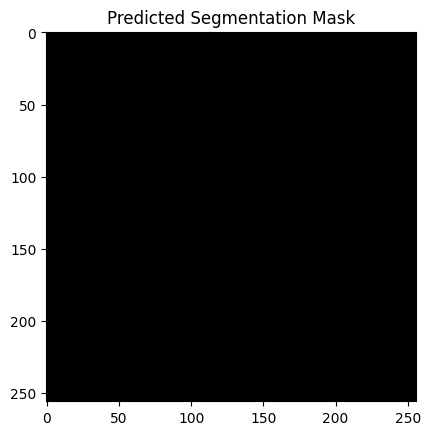

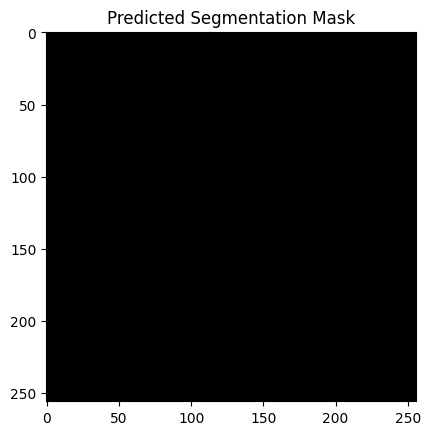

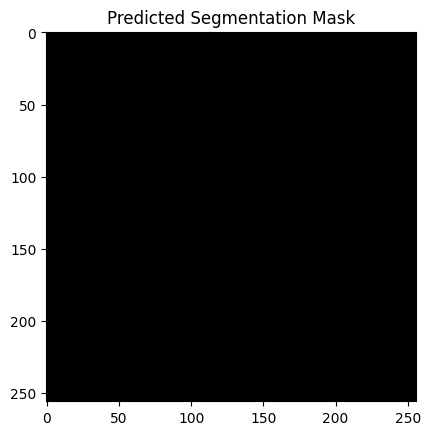

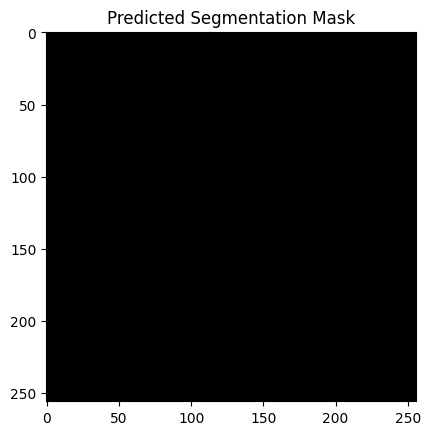

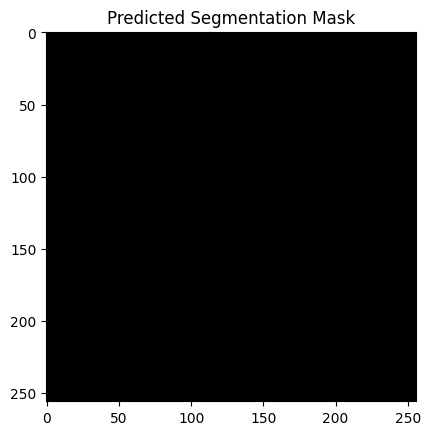

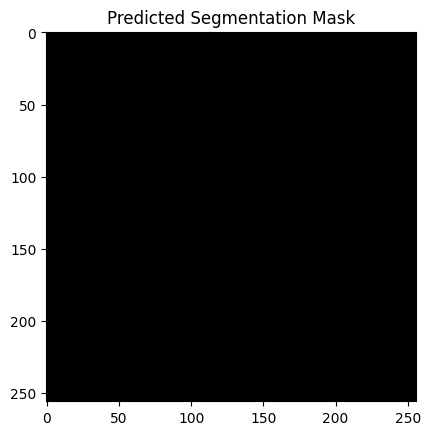

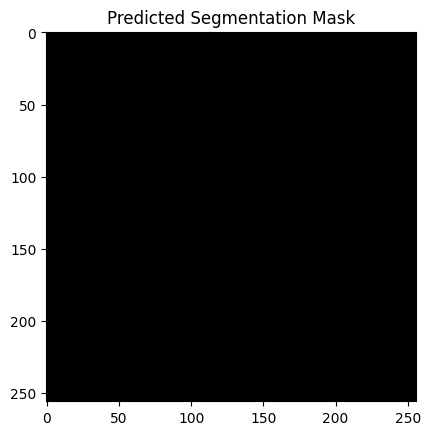

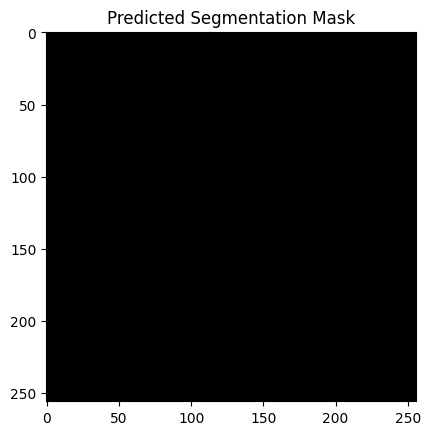

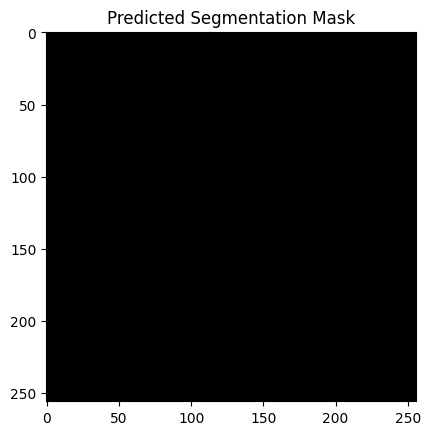

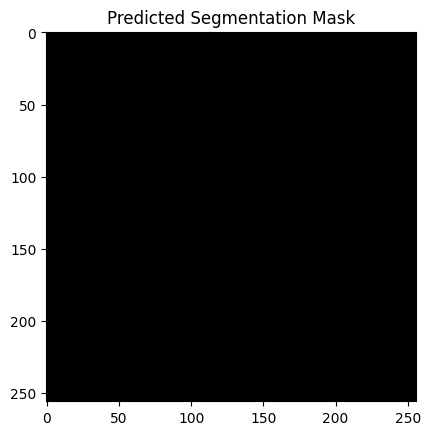

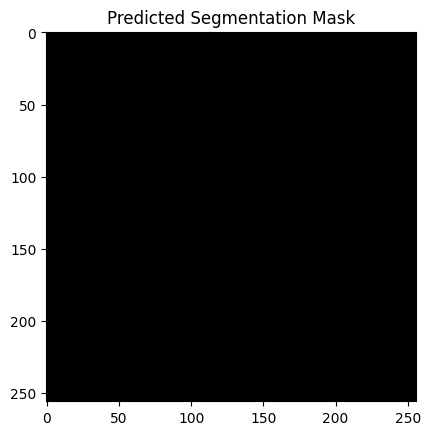

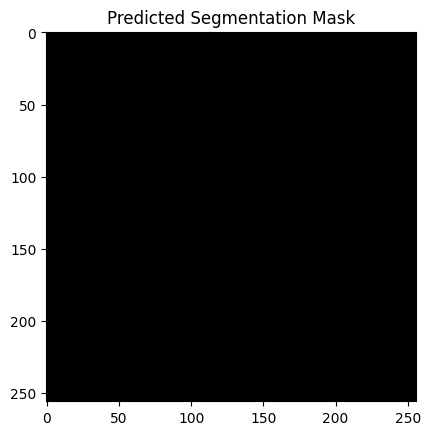

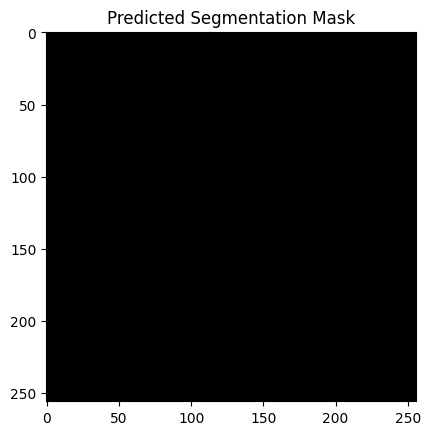

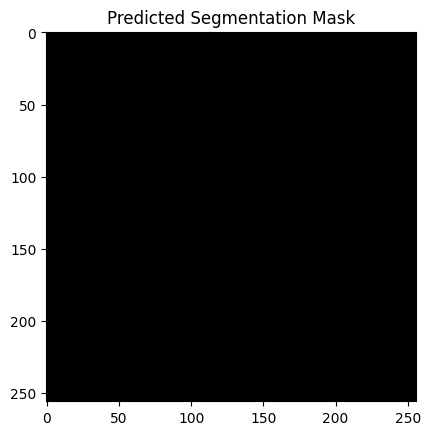

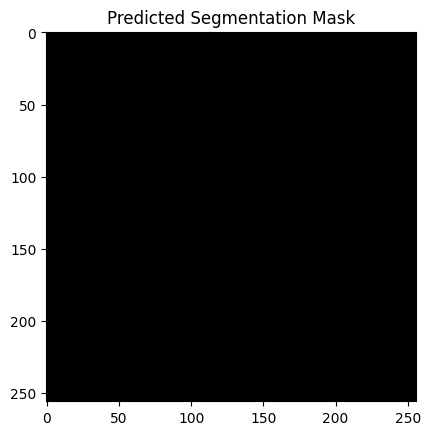

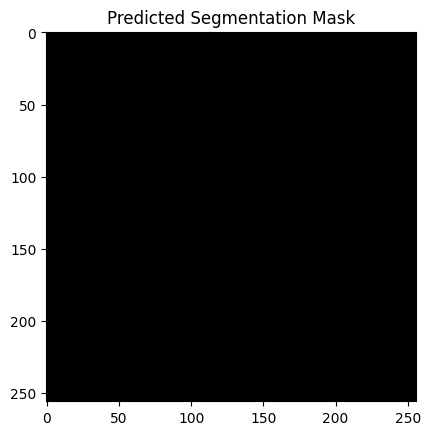

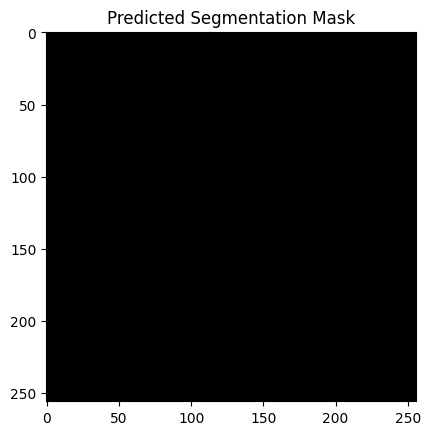

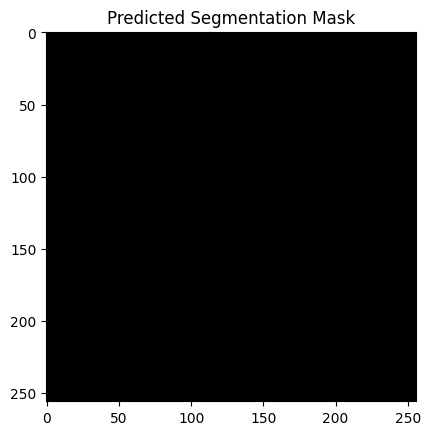

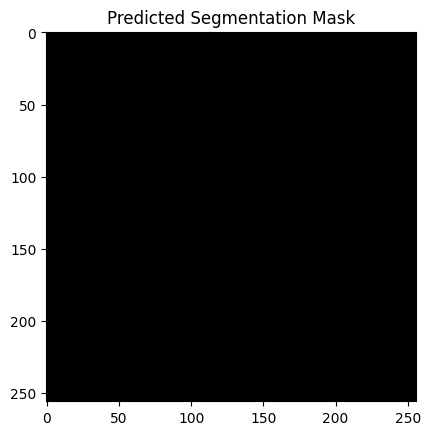

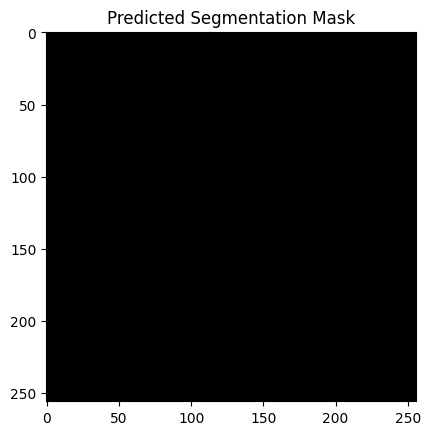

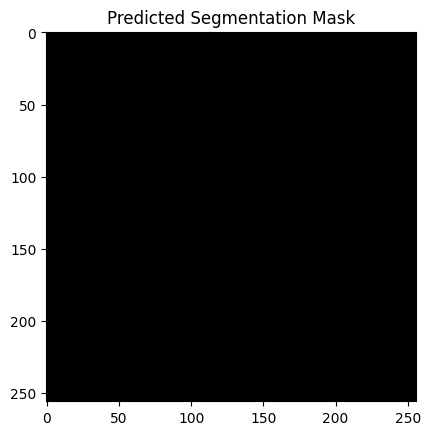

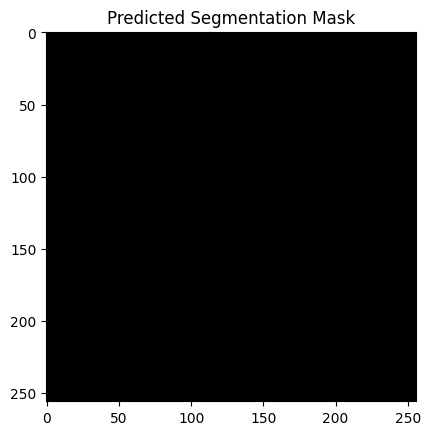

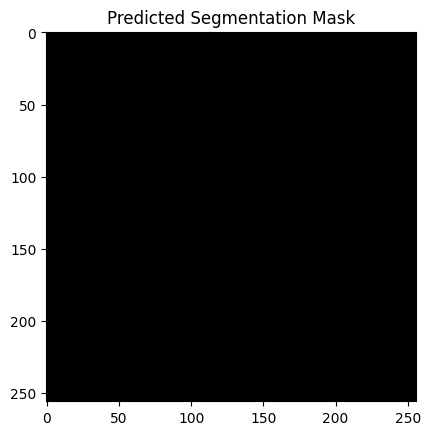

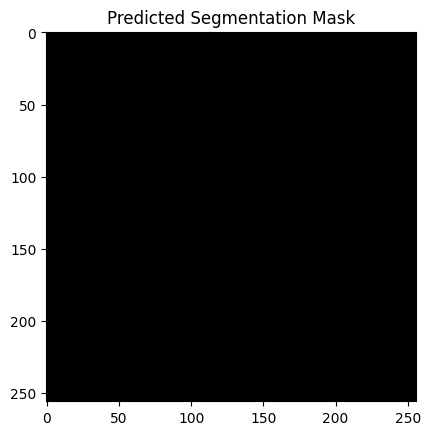

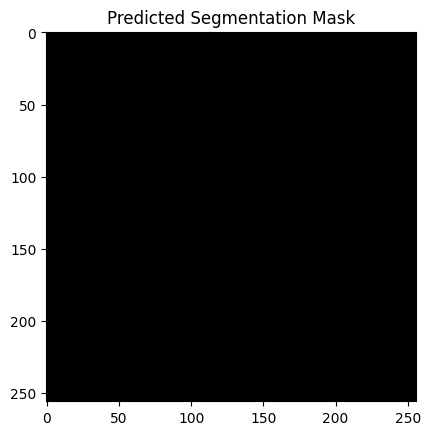

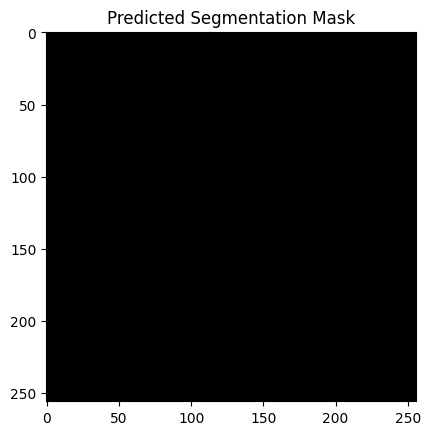

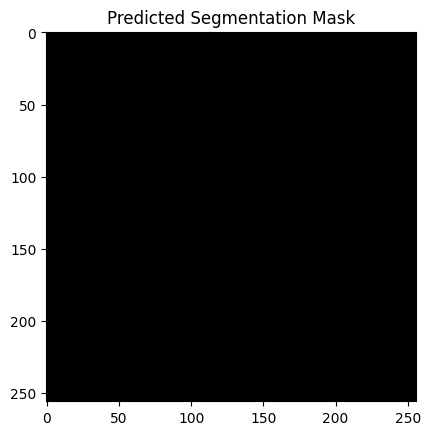

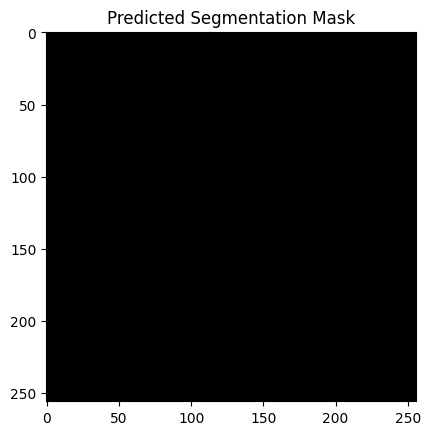

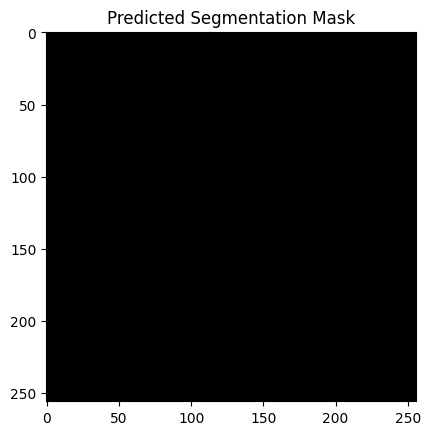

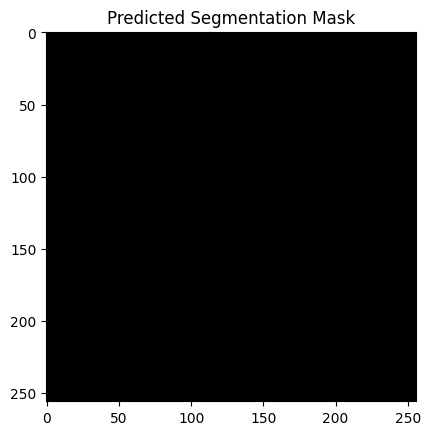

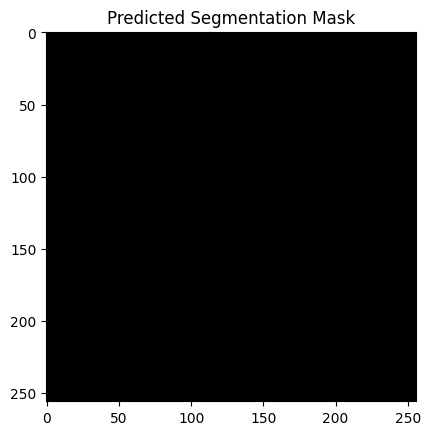

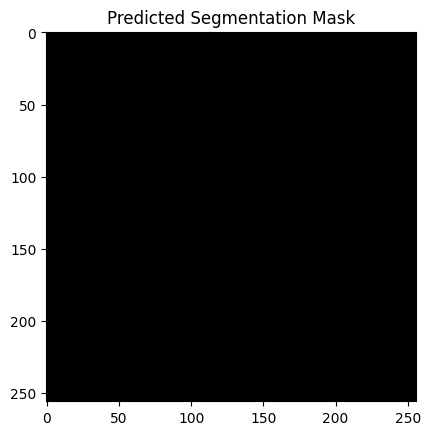

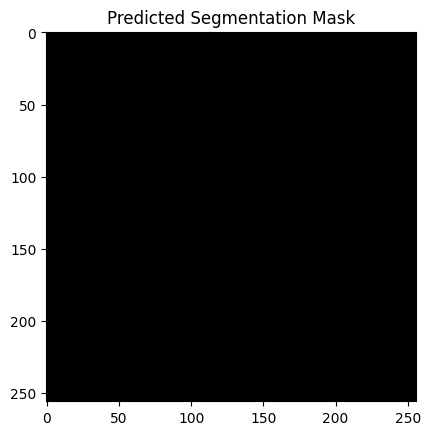

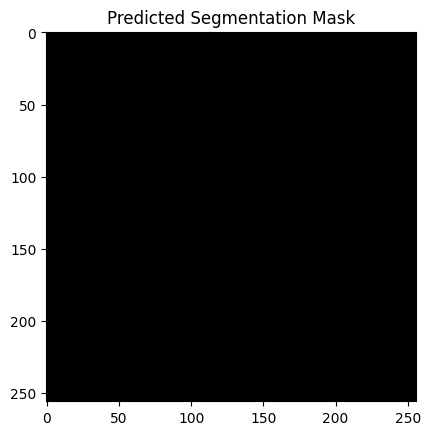

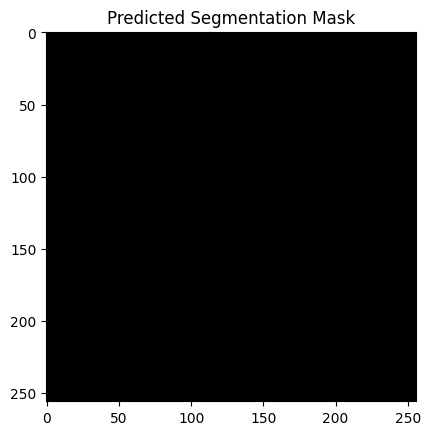

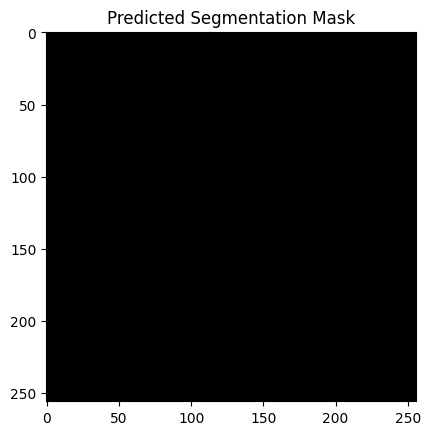

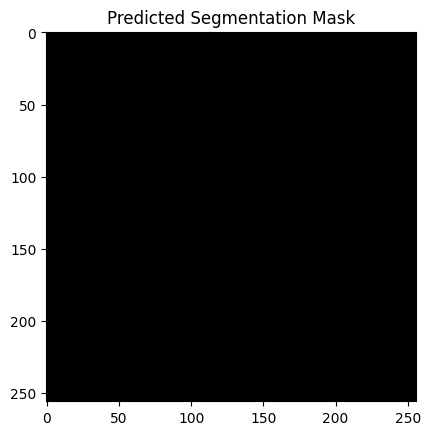

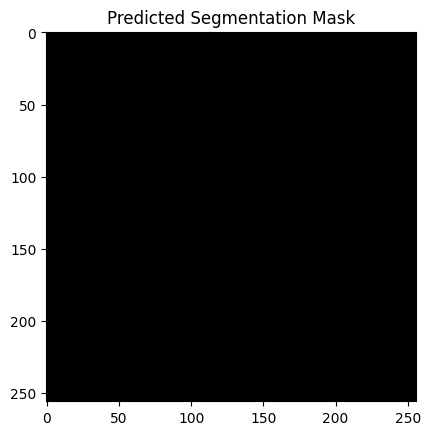

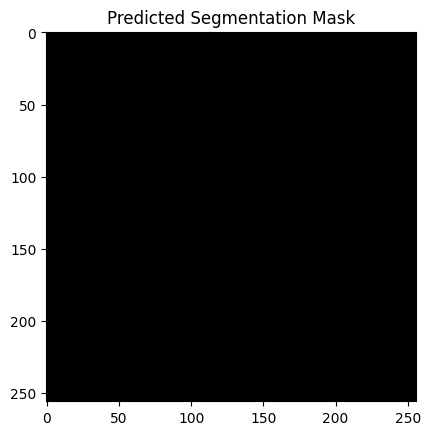

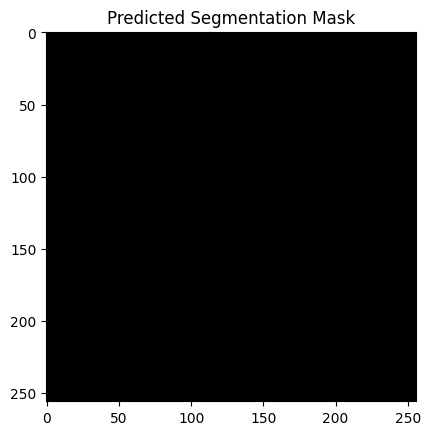

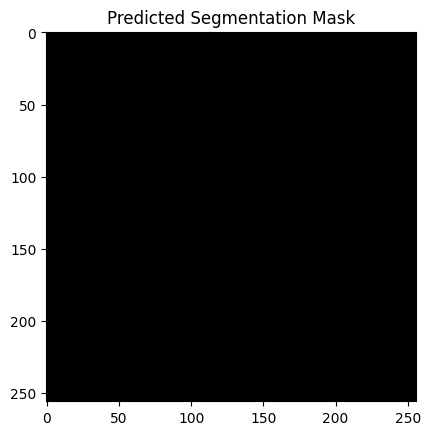

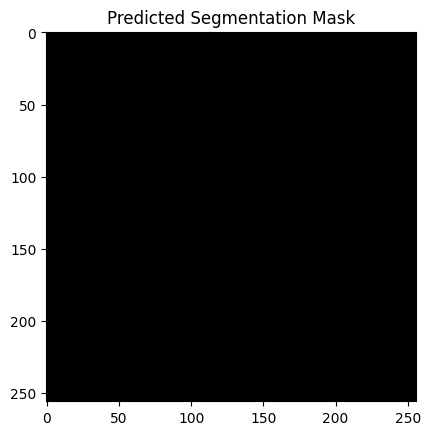

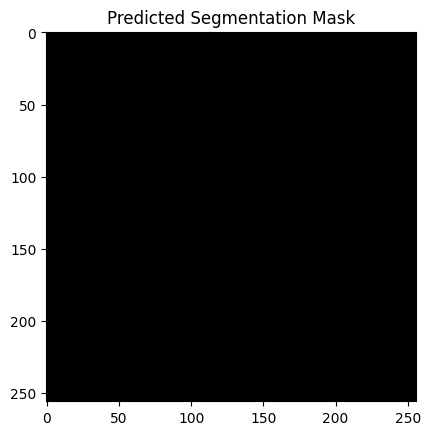

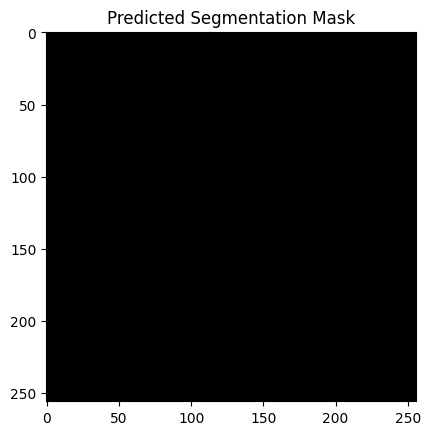

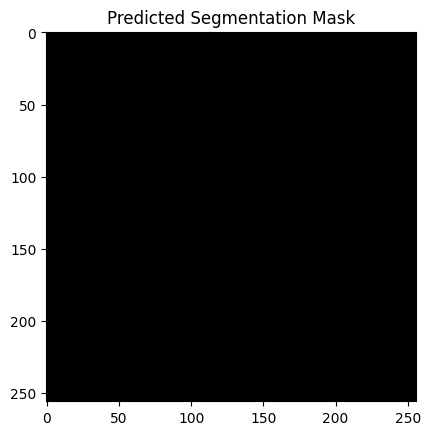

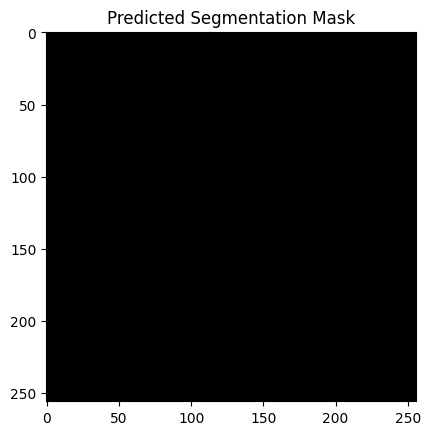

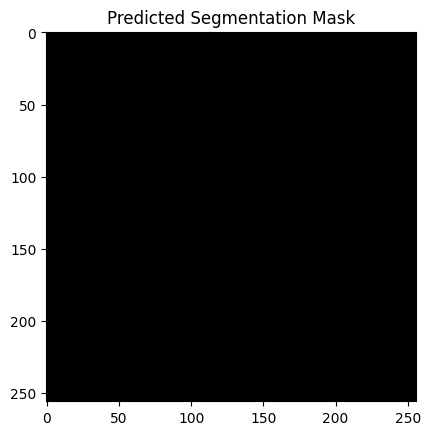

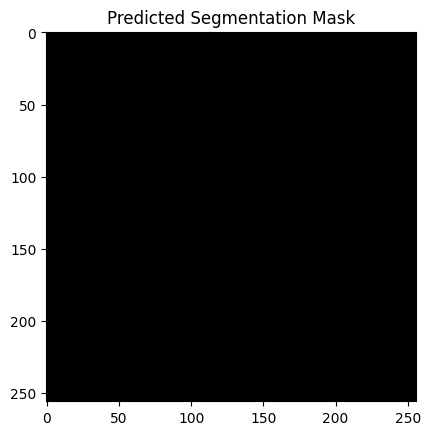

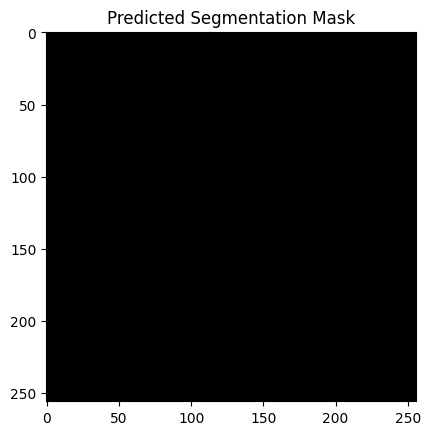

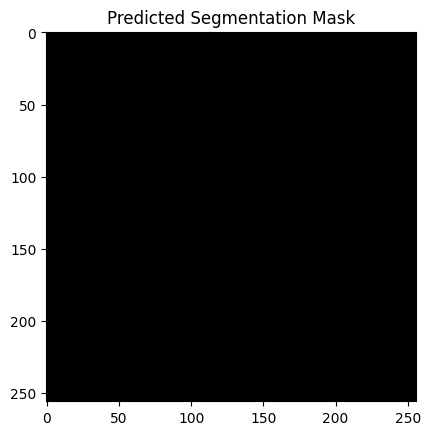

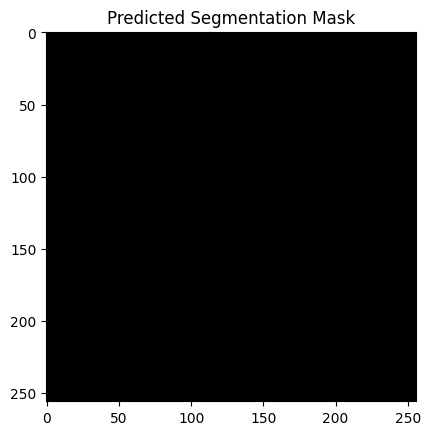

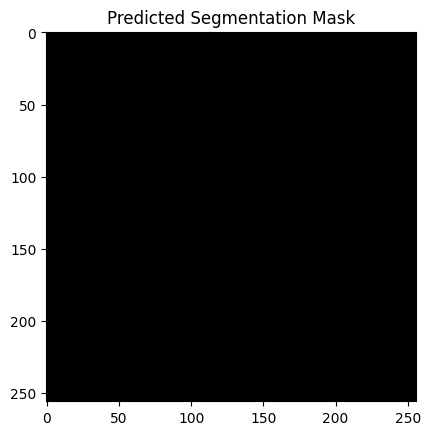

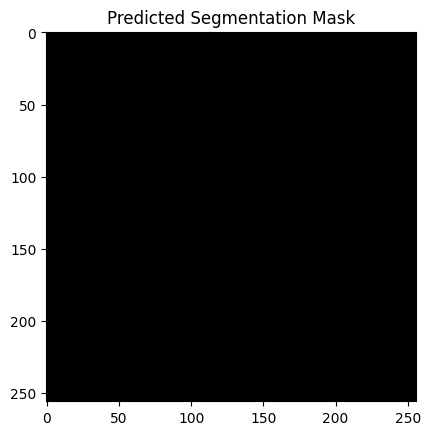

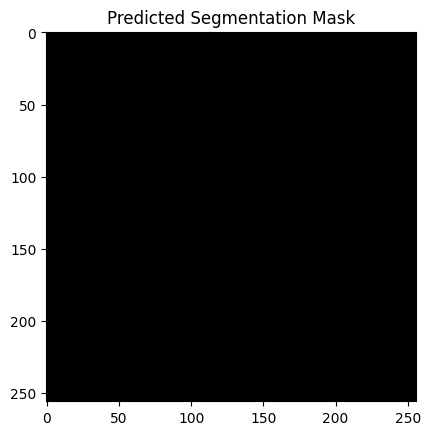

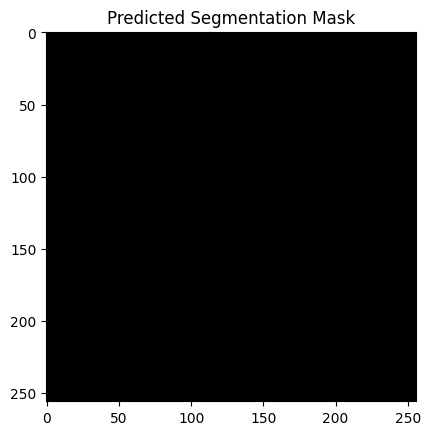

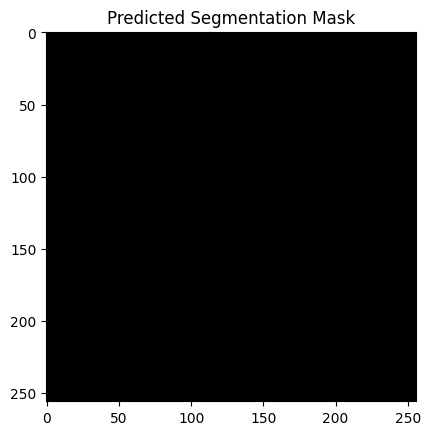

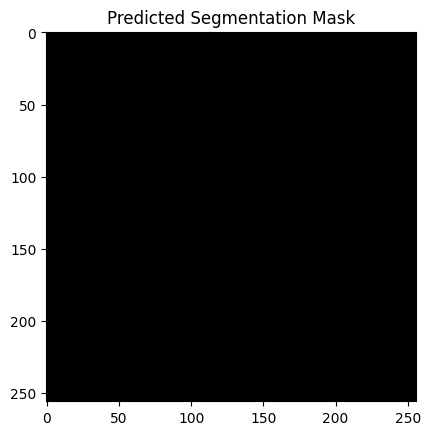

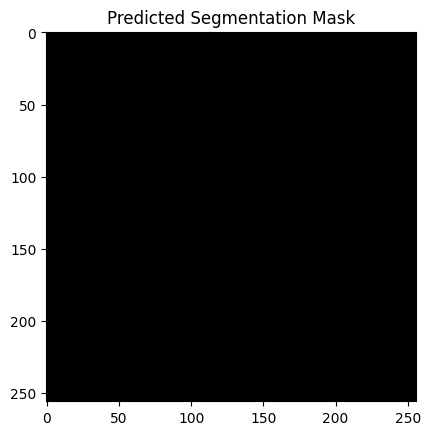

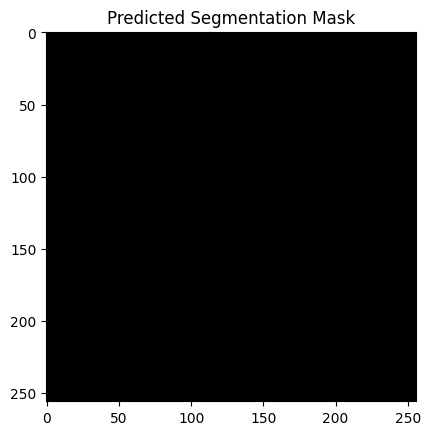

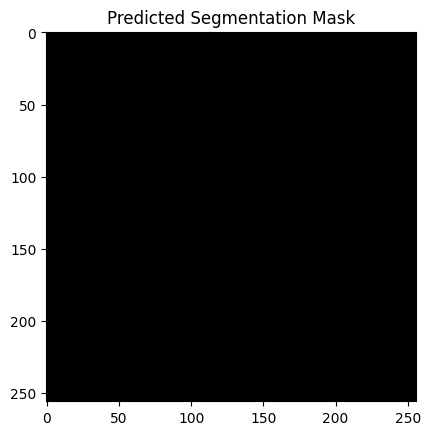

In [61]:
for i in range(len(predicted)):
    plt.imshow(predicted[i][0].cpu(), cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.show()